# 주제: 교육수준과 건강행동의 연관성

- 사용 데이터<br>
 국민건강영양조사(2023년도)
- 탐구질문<br>
 1. 교육수준에 따른 운동 실천율의 차이가 있는가?
 2. 교육수준에 따른 흡연 및 음주에 대한 경험 차이가 있는가?
 3. 교육수준에 따른 건강지표 와의 유의미한 상관관계가 있는가?
- 사용변수<br>
 성별, 나이, 교육수준, 1주일간 근력운동일수, 현재 일반담배(궐련) 흡연 여부, 1년간 음주빈도, BMI, 수축기혈압, 이완기혈압, 당화혈색소

In [ ]:
import numpy as np
import numpy.random as random
import scipy as sp
import scipy.stats as stats
import pandas as pd
from pandas import Series, DataFrame

import statsmodels.formula.api as smf
import statsmodels.api as sm
from scipy import stats
from scipy.stats import chi2_contingency, spearmanr, pearsonr
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.miscmodels.ordinal_model import OrderedModel
from statsmodels.formula.api import ols

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc('font',family='Malgun Gothic')  # 한글폰트 설정 "맑은 고딕"
import seaborn as sns
%matplotlib inline

# 소수점 3자리까지 표시
%precision 3

In [ ]:
data = pd.read_csv('education.csv', encoding = 'cp949')
data.head()

***
# 데이터 전처리

In [61]:
# 결측치 제거
data = data.dropna()

In [62]:
data = data[data['age'] >= 18]

In [63]:
cols = ['BMI', '수축기혈압', '이완기혈압', '당화혈색소']

for col in cols:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    data = data[(data[col] >= lower) & (data[col] <= upper)]

data

,sex,age,교육수준,근력운동_1주,흡연여부,음주빈도_1년,BMI,수축기혈압,이완기혈압,당화혈색소
0,1,75,1.0,6.0,8.0,8.0,23.1,142.0,88.0,6.0
1,2,70,1.0,1.0,8.0,8.0,18.3,131.0,84.0,5.5
2,2,42,3.0,1.0,8.0,5.0,21.8,103.0,61.0,5.3
4,1,43,4.0,1.0,3.0,4.0,23.3,131.0,95.0,5.5
8,1,42,4.0,1.0,1.0,2.0,22.8,128.0,82.0,5.7
...,...,...,...,...,...,...,...,...,...,...
6924,1,80,1.0,1.0,3.0,3.0,24.0,119.0,69.0,5.3
6925,2,78,1.0,5.0,8.0,2.0,29.0,139.0,85.0,5.8
6926,2,61,3.0,1.0,8.0,3.0,19.1,126.0,84.0,5.7
6927,1,57,4.0,6.0,8.0,3.0,24.9,137.0,79.0,5.4


***
## 데이터 분포도 확인(교육수준별 성별/연령대 분포)

In [ ]:
sns.countplot(x='교육수준', hue='성별', data=data)
plt.title('교육수준별 성별 분포')
plt.xlabel('교육수준')
plt.xticks(ticks=[0, 1, 2, 3], labels= edu_order)
plt.ylabel('인원 수')
plt.legend(title='성별')
plt.show()

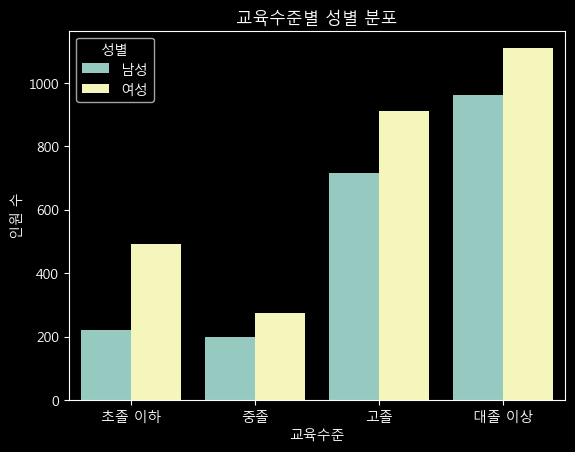

In [ ]:
cross = pd.crosstab(data['교육수준'],data['성별'])

# 각 교육수준 그룹 내에서 성별 비율 (총합 = 1)
cross_percent = cross.div(cross.sum(axis=1), axis=0)

In [ ]:
cross = pd.crosstab(data['교육수준'],data['성별'])

# 각 교육수준 그룹 내에서 성별 비율 (총합 = 1)
cross_percent = cross.div(cross.sum(axis=1), axis=0)
cross_percent.plot(kind='bar', stacked=True, figsize=(7, 5))

plt.title('성별에 따른 교육수준 비율')
plt.xlabel('성별')
plt.ylabel('비율')
plt.ylim(0, 1.05)
plt.legend(title='교육수준', loc='upper right')
plt.xticks(ticks=[0, 1, 2, 3], labels= ['초졸 이하', '중졸', '고졸', '대졸이상'], rotation = 0)
plt.tight_layout()
plt.show()

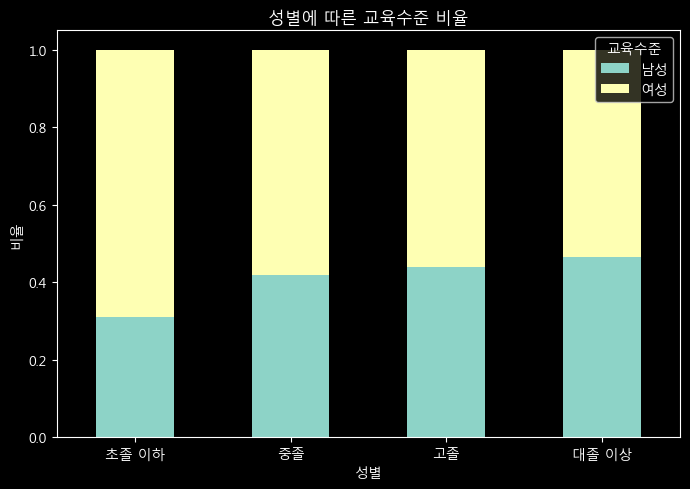

In [ ]:
cross = pd.crosstab(data['성별'], data['교육수준'])
cross = cross[[1,2,3,4]] 
cross_percent = cross.div(cross.sum(axis=1), axis=0)  

In [ ]:
cross_percent.plot(kind='bar',
                   stacked=True,
                   figsize=(6, 5))

plt.title('성별에 따른 교육수준 비율')
plt.xlabel('성별')
plt.xticks(rotation = 0)
plt.ylabel('비율')
plt.ylim(0, 1.05)
plt.legend(title='교육수준', labels = ['초졸 이하', '중졸', '고졸', '대졸 이상'], loc='upper right')
plt.tight_layout()
plt.show()

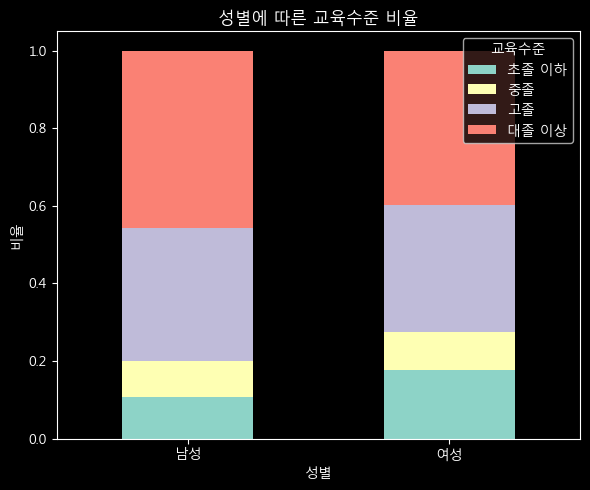

In [ ]:
sns.boxplot(x='교육수준', y='age', data=data)
plt.xticks(ticks=[0, 1, 2, 3], labels=['초졸 이하', '중졸', '고졸', '대졸 이상'])
plt.xlabel("교육수준")
plt.ylabel("나이")
plt.title("교육수준별 나이대 분포")
plt.show()

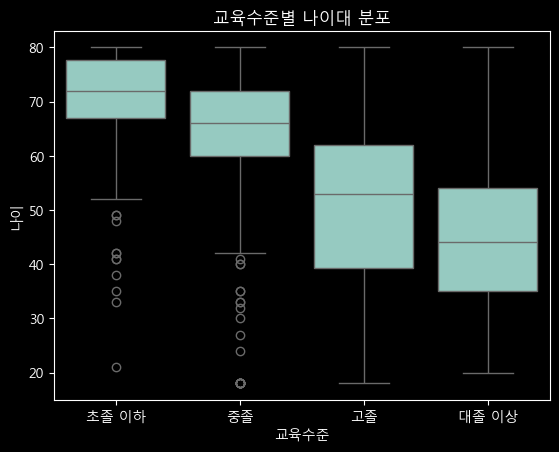

In [ ]:
edu_order = [1,2,3,4]
edu = ['초졸 이하', '중졸', '고졸', '대졸 이상']
cross = pd.crosstab(data['연령대'], data['교육수준'])
cross = cross[edu_order]  # 순서 정렬
cross_percent = cross.div(cross.sum(axis=1), axis=0)
cross_percent.plot(kind='bar', stacked=True, figsize=(8, 5))
plt.title("연령대별 교육수준 분포")
plt.xlabel("연령대")
plt.ylabel("비율")
plt.legend(title="교육수준", labels = edu, loc='upper right')
plt.tight_layout()
plt.show()

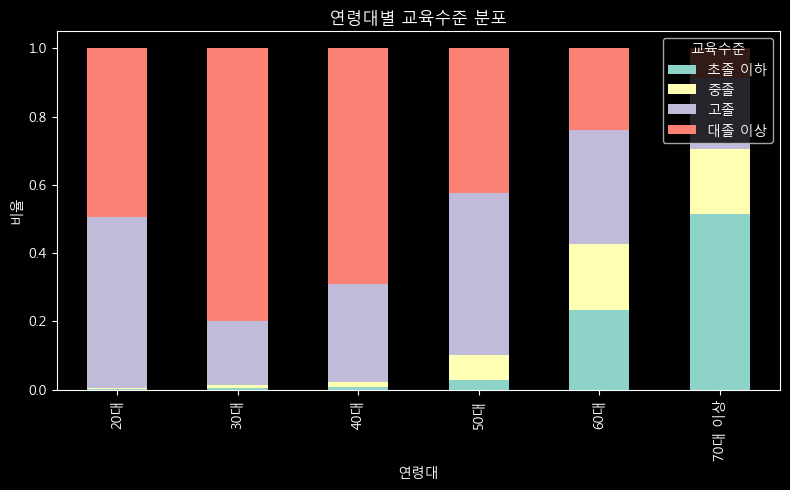

In [ ]:
sns.boxplot(x='교육수준', y='age', hue = '성별', data=data)
plt.xticks(ticks=[0, 1, 2, 3], labels=['초졸 이하', '중졸', '고졸', '대졸 이상'])
plt.xlabel("교육수준")
plt.ylabel("나이")
plt.title("성별, 교육수준별 나이대 분포")
plt.show()

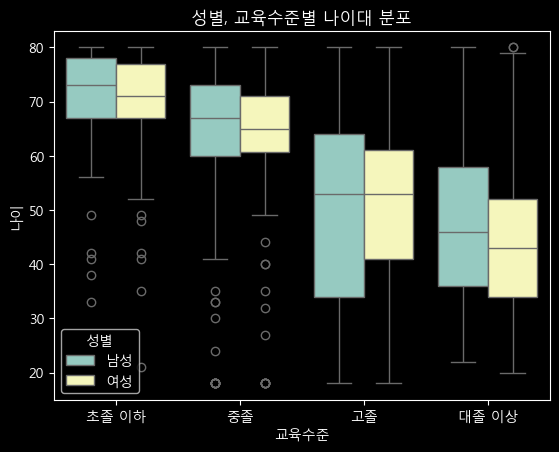

In [ ]:
sns.pointplot(x='교육수준', y='age', hue='성별', data=data)
plt.title("성별, 교육수준별 평균 나이 (신뢰구간 포함)")
plt.xticks(ticks=[0, 1, 2, 3], labels=['초졸 이하', '중졸', '고졸', '대졸 이상'])
plt.tight_layout()
plt.show()

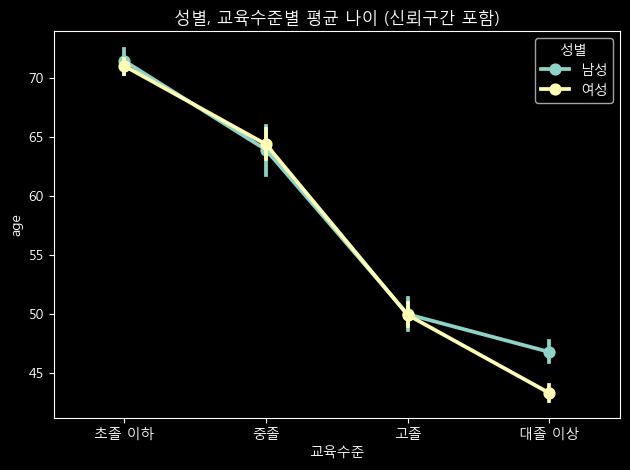

***
## 탐구질문1. 교육수준에 따른 운동 실천율의 차이가 있는가?
- 교육수준 분류  
  1: 초졸 이하  
  2: 중졸  
  3: 고졸  
  4: 대졸 이상

- 근력운동 일수 분류  
  1: 전혀 안 함  
  2: 1일  
  3: 2일  
  4: 3일  
  5: 4일  
  6: 5일 이상  

### 1. 전체 분포 확인

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_15628\2371203900.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_exercise['운동일수'] = data_exercise['근력운동_1주'].map({


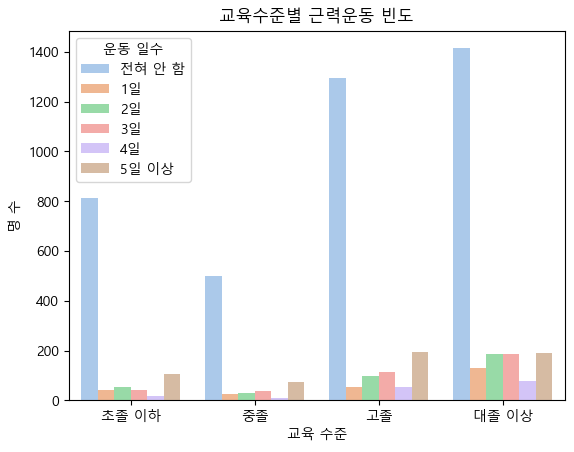

In [10]:
data_exercise = data[~data['근력운동_1주'].isin([8, 9])] #8,9 제거
#data_exercise

data_exercise['운동일수'] = data_exercise['근력운동_1주'].map({
    1: '전혀 안 함',
    2: '1일',
    3: '2일',
    4: '3일',
    5: '4일',
    6: '5일 이상'
})

sns.countplot(x='교육수준', hue='운동일수', data=data_exercise, palette = 'pastel',
              hue_order=['전혀 안 함', '1일', '2일', '3일', '4일', '5일 이상'])
plt.xticks(ticks=[0, 1, 2, 3], labels=['초졸 이하', '중졸', '고졸', '대졸 이상'])
plt.title('교육수준별 근력운동 빈도')
plt.xlabel('교육 수준')
plt.ylabel('명 수')
plt.legend(title='운동 일수')
plt.show()

In [11]:
#운동 일수 -> 운동여부 (0: 안함, 1 : 함)
data_exercise['운동여부'] = data_exercise['운동일수'].apply(lambda x: 0 if x == '전혀 안 함' else 1)

ex_cross = pd.crosstab(data_exercise['교육수준'], data_exercise['운동여부'], normalize='index')
ex_cross.index = ex_cross.index.map({1: '초졸 이하', 2: '중졸', 3: '고졸', 4: '대졸 이상'})

ex_cross

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_15628\2632101623.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_exercise['운동여부'] = data_exercise['운동일수'].apply(lambda x: 0 if x == '전혀 안 함' else 1)


운동여부,0,1
교육수준,,
초졸 이하,0.753946,0.246054
중졸,0.734904,0.265096
고졸,0.714680,0.285320
대졸 이상,0.646386,0.353614


### 1-1. 운동여부(비율)에 따른 누적막대그래프

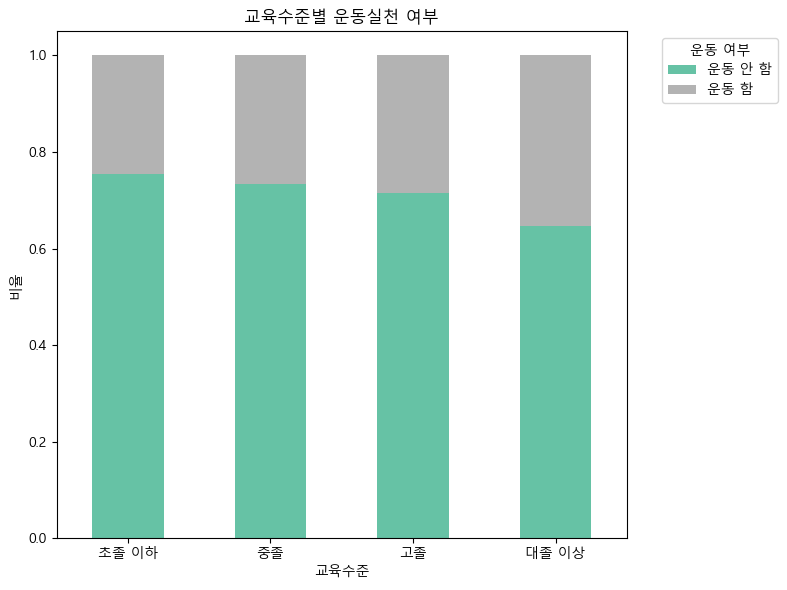

In [12]:
ex_cross.columns = ['운동 안 함', '운동 함']

ex_cross.plot(kind='bar', stacked=True, colormap='Set2', figsize=(8, 6))
plt.title("교육수준별 운동실천 여부")
plt.xlabel("교육수준")
plt.ylabel("비율")
plt.xticks(rotation = 0)
plt.legend(title="운동 여부", bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

- 운동일수의 이진분류를 통해 운동여부에 초점을 맞춘 경우, 전체적으로 운동을 하지 않는 비율이 더 많지만 교육수준이 높을수록 운동 실천 비율이 더 높았으며 특히 대졸 이상의 집단에서 운동을 하는 비율이 가장 높게 나타남

### 2. chi^2 검정

In [13]:
ex = pd.crosstab(data_exercise['교육수준'], data_exercise['운동여부'])
ex.index = ex.index.map({1: '초졸 이하', 2: '중졸', 3: '고졸', 4: '대졸 이상'})
ex

운동여부,0,1
교육수준,,
초졸 이하,812,265
중졸,499,180
고졸,1295,517
대졸 이상,1413,773


In [14]:
chi2, p, dof, expected = sp.stats.chi2_contingency(ex)
print(f"Chi2 통계량: {chi2:.3f}")
print(f"p-value: {p}")
print(f"자유도: {dof}")

Chi2 통계량: 50.435
p-value: 6.454454975587645e-11
자유도: 3


- H0 : 교육수준과 운동실천 여부는 관련이 없다.
- H1 : 교육수준과 운동실천 여부 관련이 있다.
- chi^2 검정 결과 p-value가 0.05 보다 작기 때문에 교육수준과 운동실천은 유의미한 관계가 있다고 볼 수 있음

### 3. 로지스틱 회귀분석

In [16]:
ex_model = data[data['근력운동_1주'].isin([1, 2, 3, 4, 5, 6])].copy()
ex_model['운동여부'] = ex_model['근력운동_1주'].apply(lambda x: 0 if x == 1 else 1)
ex_model['교육수준'] = ex_model['교육수준'].map({
    1: '초졸 이하', 2: '중졸', 3: '고졸', 4: '대졸 이상'})
ex_model['sex'] = ex_model['sex'].map({1: 'M', 2: 'F'})

ex_model = ex_model[['운동여부', '교육수준', 'age', 'sex']].dropna()

In [17]:
model = smf.glm(
    formula = "운동여부 ~ 교육수준 + age + sex", 
    data = ex_model, 
    family = sm.families.Binomial()).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                   운동여부   No. Observations:                 5754
Model:                            GLM   Df Residuals:                     5748
Model Family:                Binomial   Df Model:                            5
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3359.6
Date:                Sun, 08 Jun 2025   Deviance:                       6719.3
Time:                        23:49:44   Pearson chi2:                 5.74e+03
No. Iterations:                     4   Pseudo R-squ. (CS):            0.05499
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -0.7899      0.100     -7.885      0.000      -0.986      -0.594
교육수준[T.대졸 이상]     0.2598      0.071      3.683      0.000       0.122       0.398
교육수준[T.중졸]       -0.0423      0.104     -0.406      0.685      -0.246       0.162
교육수준[T.초졸 이하]    -0.0517      0.091     -0.568      0.570      -0.230       0.127
sex[T.M]          0.8842      0.059     14.914      0.000       0.768       1.000
age              -0.0113      0.002     -7.035      0.000      -0.014      -0.008
=================================================================================
"""

기존 그룹: 고졸  
교육수준과 운동여부의 관계의 명확한 파악을 위해 통제변수로 성별과 나이 포함  

- 대졸 이상은 고졸보다 운동할 가능성이 평균적으로 0.26 높음
- 중졸은 고졸보다 운동할 가능성이 평균적으로 0.04 낮음, p-value > 0.05 이므로 통계적으로 유의미하지 않음
- 초졸 이하는 고졸보다 운동할 가능성이 평균적으로 0.05 낮음, p-value > 0.05 이므로 통계적으로 유의미하지 않음
- 성별의 경우 남성보다 여성의 운동할 가능성이 평균적으로 0.88 높음
- 나이의 경우 나이가 증가할수록 운동할 가능성이 평균적으로 0.01 낮음

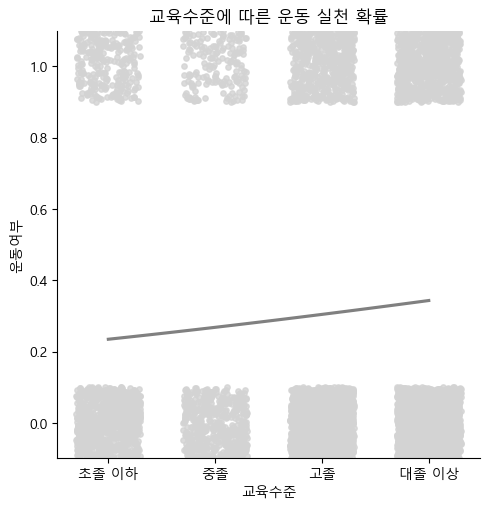

In [18]:
#lmplot을 이용한 시각화
edu_order = {'초졸 이하': 1, '중졸': 2, '고졸': 3, '대졸 이상': 4}
ex_model['교육수준_label'] = ex_model['교육수준'].map(edu_order).astype(int)

sns.lmplot(x="교육수준_label", y="운동여부",
           data=ex_model,
           ci = True,
           logistic=True,
           scatter_kws={"color": "lightgrey", "s": 15},
           line_kws={"color": "grey"},
           x_jitter=0.3, y_jitter=0.1)

plt.xticks([1, 2, 3, 4], ['초졸 이하', '중졸', '고졸', '대졸 이상'])
plt.xlabel("교육수준")
plt.ylabel("운동여부")
plt.title("교육수준에 따른 운동 실천 확률")
plt.ylim(-0.1, 1.1)
plt.show()

 - 교육수준이 높아질수록 운동 실천 가능성이 유의하게 증가
 - 회귀선의 경우 양의 관계를 보임

***
## 탐구질문2. 교육수준에 따른 흡연 및 음주에 대한 경험 차이가 있는가?

## 2-1) 교육수준과 흡연여부
- 현재 흡연여부 분류  
  1: 매일 피움  
  2: 가끔 피움  
  3: 과거엔 피웠으나 현재 피우지 않음  
  8: 비해당
    
### 1. 전체 분포 확인

In [ ]:
data_smoke = data[data['흡연여부'].isin([1, 2, 3, 8])] 
data_smoke

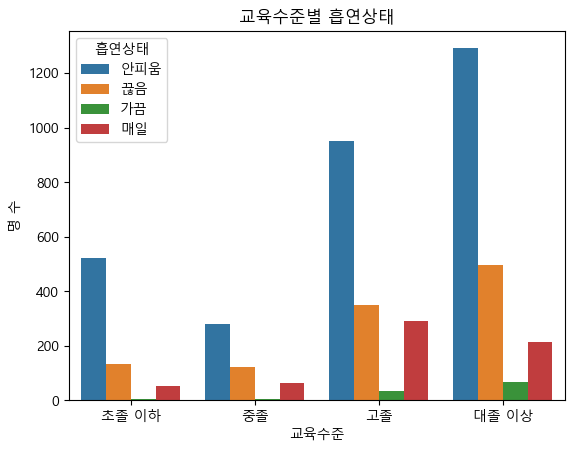

In [66]:
data_smoke['흡연상태'] = data_smoke['흡연여부'].map({1:'매일', 2:'가끔', 3:'끊음', 8: '안피움'})

smoke_order = ['안피움', '끊음', '가끔', '매일']
sns.countplot(x='교육수준', hue='흡연상태', data=data_smoke, hue_order=smoke_order)
plt.xticks(ticks=[0, 1, 2, 3], labels=['초졸 이하', '중졸', '고졸', '대졸 이상'])
plt.title('교육수준별 흡연상태')
plt.xlabel('교육수준')
plt.ylabel('명 수')
plt.legend(title='흡연상태')
plt.show()

- 모든 교육수준에서 금연이 가장 많은것으로 나타남

### 1-1. 흡연상태(비율)에 따른 누적막대그래프

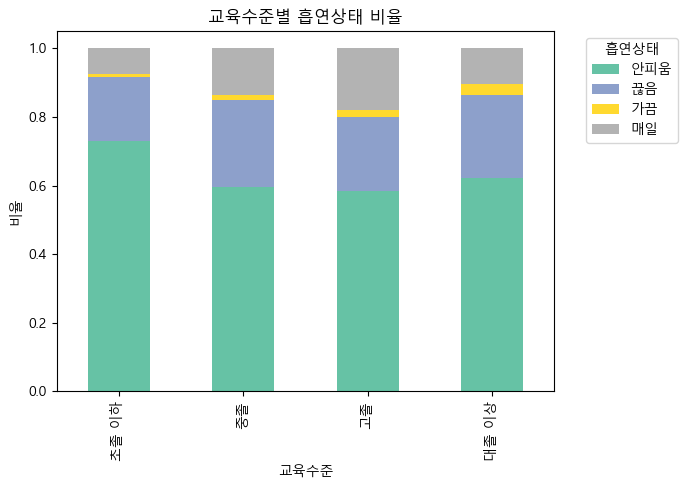

In [67]:
smoke_order = ['안피움', '끊음', '가끔', '매일']

smoke_cross = pd.crosstab(data_smoke['교육수준'], data_smoke['흡연상태'], normalize='index')
smoke_cross = smoke_cross[smoke_order]

smoke_cross.plot(kind='bar', stacked=True, colormap='Set2', figsize=(7,5))
plt.xticks(ticks=[0, 1, 2, 3], labels=['초졸 이하', '중졸', '고졸', '대졸 이상'])
plt.title('교육수준별 흡연상태 비율')
plt.xlabel('교육수준')
plt.ylabel('비율')
plt.legend(title='흡연상태', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

- 교육수준이 높아질수록 '안 피움, 끊음' 비율이 오히려 낮아지고, '가끔, 매일 피움'의 비율은 약간 증가하는 경향이 있음
- 대졸 이상 그룹에서조차 여전히 흡연 비율이 적지 않음

### 2. chi^2 검정
교육수준과 흡연상태 사이에 통계적으로 유의미한 연관이 있는지 확인

In [68]:
smoke = pd.crosstab(data_smoke['교육수준'], data_smoke['흡연상태'])
smoke.index = smoke.index.map({1: '초졸 이하', 2: '중졸', 3: '고졸', 4: '대졸 이상'})
smoke

흡연상태,가끔,끊음,매일,안피움
교육수준,,,,
초졸 이하,5,134,54,521
중졸,6,121,65,282
고졸,33,350,292,951
대졸 이상,68,497,215,1290


In [69]:
smoke_table = pd.crosstab(data_smoke['교육수준'], data_smoke['흡연상태'])
chi2, p, dof, expected = chi2_contingency(smoke_table)

print(f"Chi2 통계량: {chi2:.3f}")
print(f"p-value: {p}")
print(f"자유도: {dof}")

Chi2 통계량: 104.733
p-value: 1.7298427739545464e-18
자유도: 9


H0: 교육 수준과 흡연상태는 관련이 없다.<br>
H1: 교육 수준과 흡연상태는 관련이 있다. 

- p-value가 0.05보다 작기 때문에 교육수준과 흡연상태는 관련이 있다.

### 3. 다중회귀분석
- 흡연 여부를 이진변수로 생성  
  0: 비흡연 (안 피움, 끊음)  
  1: 흡연 (가끔, 매일 피움)    

In [72]:
data_smoke['흡연이진'] = data_smoke['흡연상태'].map({
    '끊음': 0,
    '안피움': 0,
    '가끔': 1,
    '매일': 1
})

smoke_data = data_smoke[['흡연이진', '교육수준', 'age', 'sex']].dropna()

smoke_model = smf.glm(
    formula="흡연이진 ~ 교육수준 + age + sex", 
    data=smoke_data, 
    family=sm.families.Binomial()).fit()

smoke_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                   흡연이진   No. Observations:                 4884
Model:                            GLM   Df Residuals:                     4880
Model Family:                Binomial   Df Model:                            3
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1757.7
Date:                Mon, 09 Jun 2025   Deviance:                       3515.4
Time:                        00:07:35   Pearson chi2:                 4.60e+03
No. Iterations:                     6   Pseudo R-squ. (CS):             0.1214
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.7889      0.301      9.266      0.000       2.199       3.379
교육수준          -0.1529      0.050     -3.079      0.002      -0.250      -0.056
age           -0.0197      0.003     -6.890      0.000      -0.025      -0.014
sex           -2.1891      0.104    -21.123      0.000      -2.392      -1.986
==============================================================================
"""

- R-squared = 0.1214 : 비교적 설명력이 낮은편
- 교육수준이 1증가 할수록 흡연할 가능성이 0.15 감소
- 나이가 많아질수록 흡연할 가능성이 0.02 감소 
- 여성이 남성보다 흡연할 가능성이 2.19 낮음

## 2-2) 교육수준과 음주빈도
- 1년간 음주빈도 분류   
1: 하지않음  
2: 아주가끔 (월 1회 미만)   
3: 가끔 (월 1회 정도)  
4: 보통 (월 2-4회)  
5: 자주 (주 2-3회 정도)  
6: 매우자주 (주 4회 이상)  

### 1. 전체 분포 확인

In [ ]:
data_drink = data[~data['음주빈도_1년'].isin([8, 9])]
data_drink

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_15628\316966761.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_drink['음주빈도'] = data_drink['음주빈도_1년'].map({1:'하지않음', 2:'아주가끔', 3:'가끔',


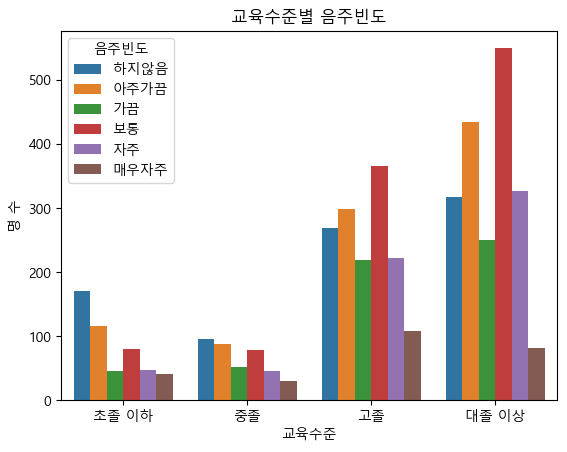

In [76]:
data_drink['음주빈도'] = data_drink['음주빈도_1년'].map({1:'하지않음', 2:'아주가끔', 3:'가끔',
                                               4:'보통', 5:'자주',6:'매우자주'})

drink_order = ['하지않음', '아주가끔', '가끔', '보통', '자주', '매우자주']
sns.countplot(x='교육수준', hue='음주빈도', data=data_drink, hue_order=drink_order)
plt.xticks(ticks=[0, 1, 2, 3], labels=['초졸 이하', '중졸', '고졸', '대졸 이상'])
plt.title('교육수준별 음주빈도')
plt.xlabel('교육수준')
plt.ylabel('명 수')
plt.legend(title='음주빈도')
plt.show()

### 1-1. 음주빈도(비율)에 따른 누적막대그래프

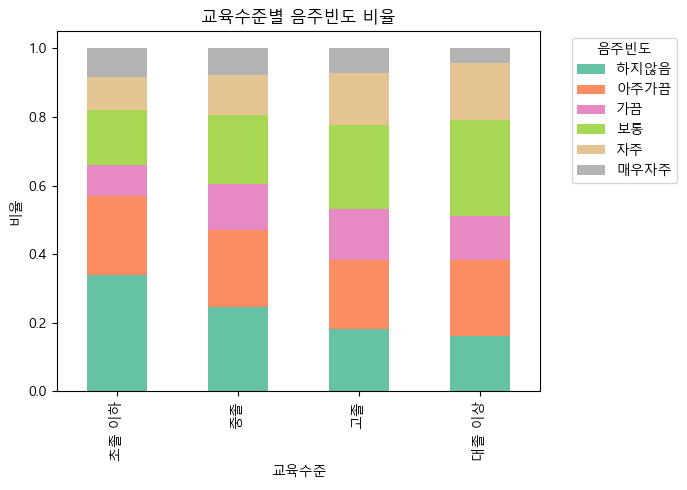

In [77]:
drink_order = ['하지않음', '아주가끔', '가끔', '보통', '자주', '매우자주']

drink_cross = pd.crosstab(data_drink['교육수준'], data_drink['음주빈도'], normalize='index')
drink_cross = drink_cross[drink_order]

drink_cross.plot(kind='bar', stacked=True, colormap='Set2', figsize=(7,5))
plt.xticks(ticks=[0, 1, 2, 3], labels=['초졸 이하', '중졸', '고졸', '대졸 이상'])
plt.title('교육수준별 음주빈도 비율')
plt.xlabel('교육수준')
plt.ylabel('비율')
plt.legend(title='음주빈도', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

- 음주를 하지 않은 비율은 교육수준이 낮아질수록 높아짐
- 음주를 한 비율은 교육수준이 올라갈수록 높아지는 경향을 보임

결론적으로, 음주 행동은 단순히 교육수준으로만 설명되기 어려움. 학력이 높다고 해서 음주 빈도가 반드시 낮다고 할 수 없음.

### 2. 상관관계 분석
- 서열형 데이터 간의 관계를 보기 위해 스피어만 상관분석 시행

In [78]:
corr, p = spearmanr(data_drink['교육수준'], data_drink['음주빈도'])
print(f"스피어만 상관계수: {corr:.3f}, p-value: {p:.3f}")

스피어만 상관계수: -0.057, p-value: 0.000


p-value값(= 0.00)은 0.05보다 작아 통계적으로 유의미하나, 상관계수값이 -0.057로 아주 약한 음의 상관관계를 보임

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_15628\174296076.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_drink['음주빈도_정수'] = data_drink['음주빈도_1년']


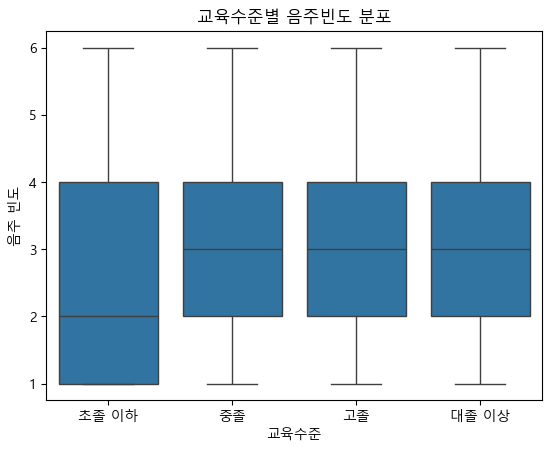

In [79]:
data_drink['음주빈도_정수'] = data_drink['음주빈도_1년']

sns.boxplot(x='교육수준', y='음주빈도_정수', data=data_drink)
plt.xticks(ticks=[0, 1, 2, 3], labels=['초졸 이하', '중졸', '고졸', '대졸 이상'])
plt.xlabel("교육수준")
plt.ylabel("음주 빈도")
plt.title("교육수준별 음주빈도 분포")
plt.show()

- 모든 교육수준에서 음주빈도가 넓게 퍼져 있으나, 초졸이하의 경우 낮은 음주빈도에 몰려있음
- 교육수준이 올라갈수록 음주빈도의 중앙값이 다소 증가하는 경향을 보임

### 3. 다중 (순서형) 로지스틱 회귀분석
- 나이가 많을수록 음주를 덜 할 가능성이 있고, 고령층의 경우 교육수준이 낮을 가능성도 존재
- 성별의 경우도 일반적으로 여성보다 남성이 음주 빈도가 높은 경우가 많으며 교육수준에도 영향이 있을 수 있음

In [80]:
data_drink['음주빈도'] = pd.Categorical(data_drink['음주빈도'], ordered=True)

drink_model = OrderedModel(
    data_drink['음주빈도'], data_drink[['교육수준', 'age', 'sex']], distr='logit')

res = drink_model.fit(method='bfgs')
res.summary()

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_15628\1737190059.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_drink['음주빈도'] = pd.Categorical(data_drink['음주빈도'], ordered=True)


Optimization terminated successfully.
         Current function value: 1.698742
         Iterations: 31
         Function evaluations: 34
         Gradient evaluations: 34


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:                   음주빈도   Log-Likelihood:                -7369.1
Model:                   OrderedModel   AIC:                         1.475e+04
Method:            Maximum Likelihood   BIC:                         1.481e+04
Date:                Mon, 09 Jun 2025                                         
Time:                        00:07:57                                         
No. Observations:                4338                                         
Df Residuals:                    4330                                         
Df Model:                           3                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
교육수준           0.0363      0.032      1.123      0.262      -0.027       0.100
age            0.0197      0.002      9.991      0.000       0.016       0.024
sex            0.2675      0.054      4.916      0.000       0.161       0.374
가끔/매우자주       -0.4098      0.205     -1.995      0.046      -0.812      -0.007
매우자주/보통       -0.7916      0.060    -13.109      0.000      -0.910      -0.673
보통/아주가끔        0.1969      0.028      7.018      0.000       0.142       0.252
아주가끔/자주       -0.1004      0.030     -3.354      0.001      -0.159      -0.042
자주/하지않음       -0.2466      0.037     -6.616      0.000      -0.320      -0.174
==============================================================================
"""

- 교육수준의 p-value > 0.05 : 유의한 관련이 없는것으로 나타남
- 나이가 1살 증가할 때 음주 빈도는 평균적으로 0.02 증가
- 남성보다 여성의 음주빈도가 평균적으로 0.27 높음

따라서, 교육수준은 음주빈도에 유의한 영향을 주지 않으며, 나이가 적고 남성일수록 낮은 음주빈도를 가질 가능성이 높음

***
## 탐구질문3. 교육수준에 따른 건강지표 와의 유의미한 상관관계가 있는가?

### 1. 교육수준에 따른 건강지표 분포
- 체질량지수(BMI) : 비만도 및 영양 상태를 나타내는 대표 지표  
- 수축기 혈압 / 이완기 혈압 : 고혈압의 진단 기준이며, 심혈관계 질환의 위험도를 반영함   
- 당화혈색소(HbA1c) : 최근 2~3개월간의 혈당 조절 상태를 나타내는 지표로, 당뇨병 및 대사 건강과 밀접한 관련이 있음  

In [ ]:
data_health = data[['sex','age','교육수준', 'BMI', '수축기혈압', '이완기혈압', '당화혈색소']].dropna()  
data_health

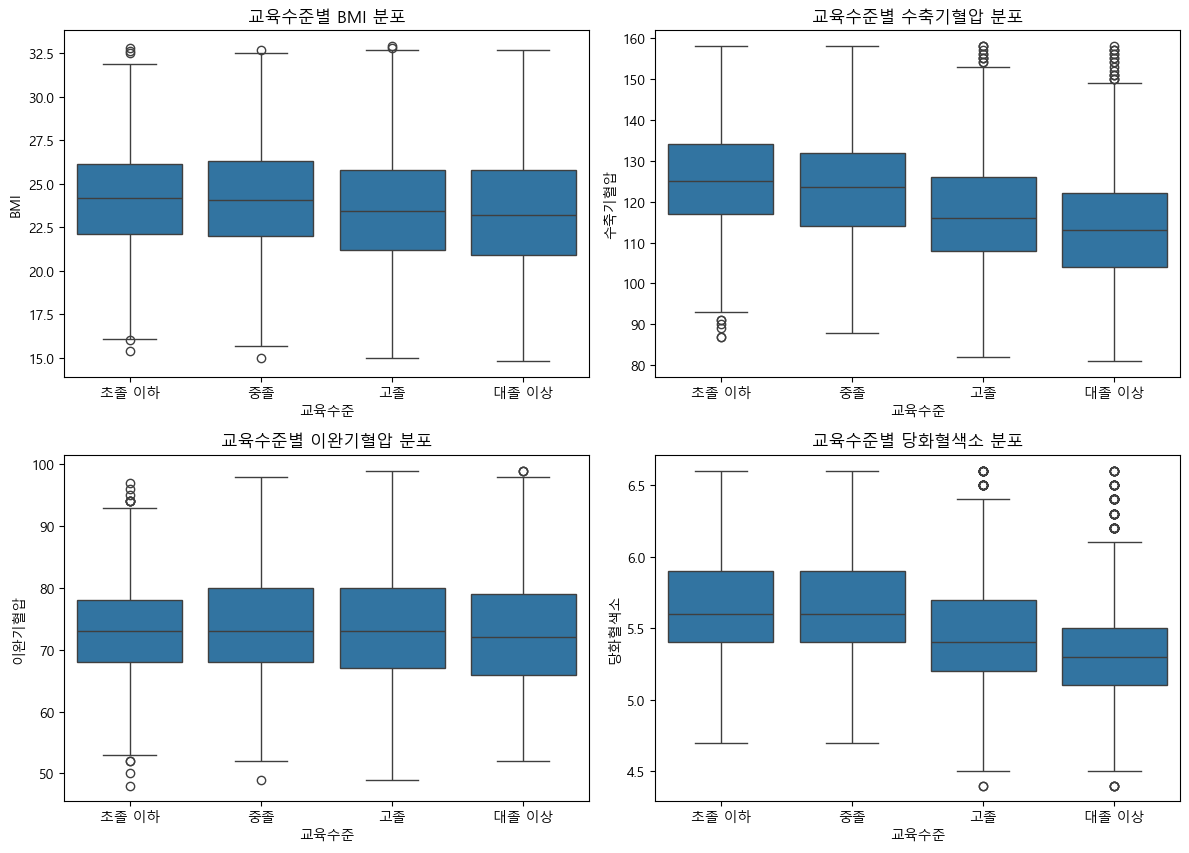

In [82]:
fig, axes = plt.subplots(2, 2, figsize=(12, 9))

xticks = [0, 1, 2, 3]
xtick_labels = ['초졸 이하', '중졸', '고졸', '대졸 이상']

sns.boxplot(x='교육수준', y='BMI', data=data_health, ax=axes[0, 0])
axes[0, 0].set_title('교육수준별 BMI 분포')
axes[0, 0].set_xticks(xticks)
axes[0, 0].set_xticklabels(xtick_labels)

sns.boxplot(x='교육수준', y='수축기혈압', data=data_health, ax=axes[0, 1])
axes[0, 1].set_title('교육수준별 수축기혈압 분포')
axes[0, 1].set_xticks(xticks)
axes[0, 1].set_xticklabels(xtick_labels)

sns.boxplot(x='교육수준', y='이완기혈압', data=data_health, ax=axes[1, 0])
axes[1, 0].set_title('교육수준별 이완기혈압 분포')
axes[1, 0].set_xticks(xticks)
axes[1, 0].set_xticklabels(xtick_labels)

sns.boxplot(x='교육수준', y='당화혈색소', data=data_health, ax=axes[1, 1])
axes[1, 1].set_title('교육수준별 당화혈색소 분포')
axes[1, 1].set_xticks(xticks)
axes[1, 1].set_xticklabels(xtick_labels)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

1. BMI
   - 교육수준별로 큰 차이는 보이지 않음
   - 전체적으로 중앙값이 23~25 사이에 존재
   - 교육수준이 높아진다고 해서 BMI가 뚜렷하게 낮다고 할 수 없음 
 
2. 수축기혈압
   - 교육수준이 낮을수록 수축기 혈압의 중앙값이 높은 경향이 있음
   - 대졸 이상의 그룹은 중앙값이 가장 낮고, 초졸 이하는 가장 높음

3. 이완기혈압
   - 교육수준에 따른 큰 차이가 존재하지 않음

4. 당화혈색소
   - 교육수준이 낮을수록 당화혈색소 수치가 높은 경향이 있음

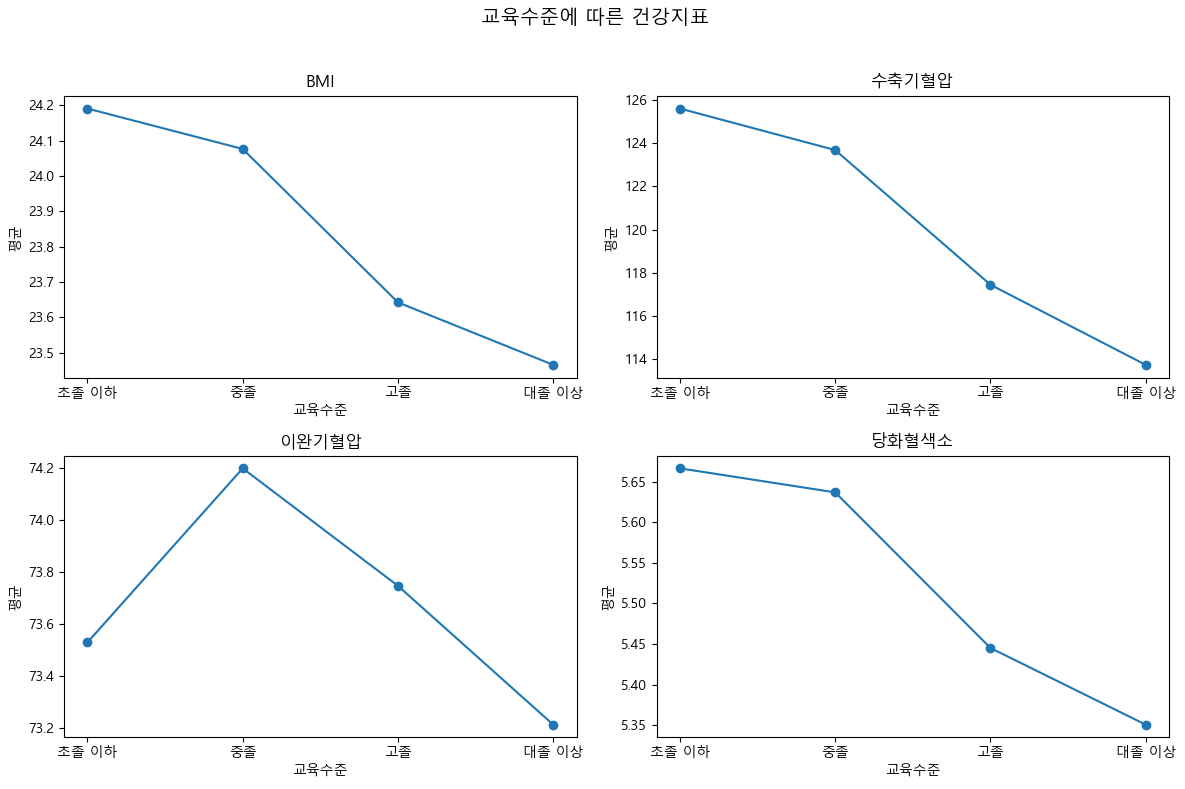

In [96]:
edu_mean = data.groupby('교육수준')[['BMI', '수축기혈압', '이완기혈압', '당화혈색소']].mean()

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

for ax, col in zip(axes.flat, ['BMI', '수축기혈압', '이완기혈압', '당화혈색소']):
    edu_mean[col].plot(marker='o', ax=ax)
    ax.set_title(col)
    ax.set_xticks([1,2,3,4])
    ax.set_xticklabels(['초졸 이하', '중졸', '고졸', '대졸 이상'])
    ax.set_ylabel('평균')

fig.suptitle("교육수준에 따른 건강지표", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

- 전반적으로 교육수준이 높을수록 BMI, 수축기혈압, 당화혈색소 수치가 감소하는 경향을 보임

### 2. 상관관계 분석
- boxplot의 시각화 경향이 실제 통계적으로 유의미한지 확인

In [83]:
cols = ['BMI', '수축기혈압', '이완기혈압', '당화혈색소']
for col in cols:
    corr, p = pearsonr(data_health['교육수준'], data_health[col])
    print(f"{col}: 상관계수={corr:.3f}, p-value={p:.3f}")

BMI: 상관계수=-0.080, p-value=0.000
수축기혈압: 상관계수=-0.315, p-value=0.000
이완기혈압: 상관계수=-0.021, p-value=0.135
당화혈색소: 상관계수=-0.298, p-value=0.000


- BMI의 경우 교육수준이 높을수록 낮아지는 경향이 있으나 약한 음의 상관관계를 보임
- 수축기 혈압의 경우 교육수준이 높을수록 낮아지는 경향이 있고, 중간정도의 음의 상관관계를 보임
- 이완기 혈압의 경우 교육수준과 상관관계가 거의 없으며, p-value > 0.05로 유의한 관계가 없음
- 당화혈색소의 경우 교육수준이 높을수록 낮아지는 경향이 있으며, 중간정도의 음의 상관관계를 보임

따라서,
1. 교육수준이 높을수록 전반적으로 건강지표가 개선되는 경향이 있음
2. 수축기혈압과 당화혈색소에서 그 경향이 나타남
3. BMI는 통계적으로 유의미하나 상관성이 매우 약하고, 이완기 혈압의 경우 상관관계가 없음

### 3. 다중회귀분석
- 통제변수인 성별과 나이를 추가해서 다중회귀분석

In [84]:
model1 = smf.ols('BMI ~ 교육수준 + age + sex', data=data_health.dropna()).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    BMI   R-squared:                       0.038
Model:                            OLS   Adj. R-squared:                  0.037
Method:                 Least Squares   F-statistic:                     63.81
Date:                Mon, 09 Jun 2025   Prob (F-statistic):           1.84e-40
Time:                        00:08:04   Log-Likelihood:                -12718.
No. Observations:                4884   AIC:                         2.544e+04
Df Residuals:                    4880   BIC:                         2.547e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     25.7301      0.351     73.292      0.000      25.042      26.418
교육수준          -0.2268      0.054     -4.202      0.000      -0.333      -0.121
age            0.0090      0.003      2.647      0.008       0.002       0.016
sex           -1.1591      0.095    -12.178      0.000      -1.346      -0.972
==============================================================================
Omnibus:                       80.707   Durbin-Watson:                   1.943
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               84.193
Skew:                           0.317   Prob(JB):                     5.22e-19
Kurtosis:                       2.897   Cond. No.                         419.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- 교육수준이 한 단계 상승할 때 BMI는 평균적으로 약 0.23 감소
- 나이가 한 살 증가할 때 BMI는 평균적으로 0.01 증가
- 남성보다 여성의 BMI가 평균적으로 1.16 낮음
- R-squared = 0.04 : 설명력이 매우 낮음, BMI에 미치는 요인은 교육수준만으로는 설명이 제한적임

In [85]:
model2 = smf.ols('수축기혈압 ~ 교육수준 + age + sex', data=data_health.dropna()).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  수축기혈압   R-squared:                       0.218
Model:                            OLS   Adj. R-squared:                  0.218
Method:                 Least Squares   F-statistic:                     454.6
Date:                Mon, 09 Jun 2025   Prob (F-statistic):          1.76e-260
Time:                        00:08:05   Log-Likelihood:                -19144.
No. Observations:                4884   AIC:                         3.830e+04
Df Residuals:                    4880   BIC:                         3.832e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    117.1997      1.309     89.553      0.000     114.634     119.765
교육수준          -1.9167      0.201     -9.525      0.000      -2.311      -1.522
age            0.2781      0.013     22.063      0.000       0.253       0.303
sex           -5.2595      0.355    -14.824      0.000      -5.955      -4.564
==============================================================================
Omnibus:                       42.409   Durbin-Watson:                   1.903
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               43.296
Skew:                           0.227   Prob(JB):                     3.97e-10
Kurtosis:                       3.083   Cond. No.                         419.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- 교육수준이 한 단계 상승할 때 수축기 혈압은 평균적으로 1.92 감소
- 나이가 한 살 증가할 때 수축기 혈압은 평균적으로 0.28 증가
- 남성보다 여성의 수축기 혈압이 평균적으로 5.26 낮음
- R-squared = 0.22 : 비교적 설명력이 낮은편

In [86]:
model3 = smf.ols('이완기혈압 ~ 교육수준 + age + sex', data=data_health.dropna()).fit()
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  이완기혈압   R-squared:                       0.064
Model:                            OLS   Adj. R-squared:                  0.064
Method:                 Least Squares   F-statistic:                     111.9
Date:                Mon, 09 Jun 2025   Prob (F-statistic):           4.22e-70
Time:                        00:08:05   Log-Likelihood:                -17416.
No. Observations:                4884   AIC:                         3.484e+04
Df Residuals:                    4880   BIC:                         3.487e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     70.9949      0.919     77.289      0.000      69.194      72.796
교육수준           0.6309      0.141      4.467      0.000       0.354       0.908
age            0.1083      0.009     12.235      0.000       0.091       0.126
sex           -3.2090      0.249    -12.886      0.000      -3.697      -2.721
==============================================================================
Omnibus:                       82.899   Durbin-Watson:                   1.867
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               85.485
Skew:                           0.313   Prob(JB):                     2.74e-19
Kurtosis:                       2.835   Cond. No.                         419.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- 교육수준이 한 단계 상승할 때 이완기 혈압은 평균적으로 0.63 증가
- 나이가 한 살 증가할 때 이완기 혈압은 평균적으로 0.11 증가
- 남성보다 여성의 이완기 혈압이 평균적으로 3.20 낮음
- R-squared = 0.06 : 설명력이 매우 낮음, 이완기 혈압에 미치는 요인은 교육수준만으로는 설명이 제한적임

In [87]:
model4 = smf.ols('당화혈색소 ~ 교육수준 + age + sex', data=data_health.dropna()).fit()
model4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  당화혈색소   R-squared:                       0.250
Model:                            OLS   Adj. R-squared:                  0.250
Method:                 Least Squares   F-statistic:                     542.3
Date:                Mon, 09 Jun 2025   Prob (F-statistic):          3.61e-304
Time:                        00:08:05   Log-Likelihood:                -1699.2
No. Observations:                4884   AIC:                             3406.
Df Residuals:                    4880   BIC:                             3432.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.9656      0.037    135.017      0.000       4.893       5.038
교육수준          -0.0139      0.006     -2.455      0.014      -0.025      -0.003
age            0.0113      0.000     31.918      0.000       0.011       0.012
sex           -0.0375      0.010     -3.764      0.000      -0.057      -0.018
==============================================================================
Omnibus:                      199.634   Durbin-Watson:                   1.924
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              237.632
Skew:                           0.465   Prob(JB):                     2.51e-52
Kurtosis:                       3.551   Cond. No.                         419.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- 교육수준이 한 단계 상승할 때 당화혈색소는 평균적으로 0.01 감소
- 나이가 한 살 증가할 때 당화혈색소는 평균적으로 0.01 증가
- 남성보다 여성의 당화혈색소는 평균적으로 0.04 낮음
- R-squared = 0.25 : 비교적 설명력이 낮은편

### 4. 통계적 유의성(ANOVA, Tukey's)

In [88]:
model1 = ols('BMI ~ 교육수준', data=data_health).fit()
anova_table1 = sm.stats.anova_lm(model1, typ=2)
anova_table1

,sum_sq,df,F,PR(>F)
교육수준,345.184911,1.0,31.232579,2.413239e-08
Residual,53956.246702,4882.0,NaN,NaN


- F = 31.2, p-value ≈ 0 : 교육수준에 따라 BMI 평균에 유의미한 차이가 존재

In [89]:
tukey1 = pairwise_tukeyhsd(endog=data_health['BMI'],
                          groups=data_health['교육수준'],
                          alpha=0.05)
print(tukey1)

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   1.0    2.0  -0.1145 0.9377 -0.6208  0.3917  False
   1.0    3.0  -0.5492 0.0014 -0.9328 -0.1656   True
   1.0    4.0  -0.7261    0.0  -1.097 -0.3553   True
   2.0    3.0  -0.4347 0.0593 -0.8807  0.0113  False
   2.0    4.0  -0.6116 0.0017 -1.0467 -0.1766   True
   3.0    4.0   -0.177 0.3751 -0.4601  0.1062  False
----------------------------------------------------


- tukey 사후검정 결과 고졸 및 대졸 이상집단은 초졸 이하및 중졸 집단보다 BMI가 유의하게 낮음
- 낮은 교육수준(초졸 이하/중졸)과 상대적으로 높은 교육수준(고졸/대졸 이상) 간에 유의미한 차이가 있고, 고졸과 대졸 이상 간에는 BMI 차이가 명확하지 않음

In [90]:
model2 = ols('수축기혈압 ~ 교육수준', data=data_health).fit()
anova_table2 = sm.stats.anova_lm(model2, typ=2)
anova_table2

,sum_sq,df,F,PR(>F)
교육수준,92338.548550,1.0,538.740464,3.874783e-113
Residual,836760.600508,4882.0,NaN,NaN


- F = 538.7, p-value ≈ 0 : 교육수준에 따른 수축기 혈압 평균에 유의미한 차이가 존재
- F 값이 크기때문에 집단 간 차이가 뚜렷하다고 할 수 있음

In [91]:
tukey2 = pairwise_tukeyhsd(endog=data_health['수축기혈압'],
                          groups=data_health['교육수준'],
                          alpha=0.05)
print(tukey2)

 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1 group2 meandiff p-adj   lower    upper   reject
------------------------------------------------------
   1.0    2.0  -1.9222 0.0631  -3.9138   0.0694  False
   1.0    3.0  -8.1559    0.0  -9.6651  -6.6467   True
   1.0    4.0 -11.8655    0.0 -13.3244 -10.4065   True
   2.0    3.0  -6.2337    0.0  -7.9884   -4.479   True
   2.0    4.0  -9.9433    0.0  -11.655  -8.2316   True
   3.0    4.0  -3.7096    0.0  -4.8235  -2.5956   True
------------------------------------------------------


- 초졸 이하와 중졸 간만 유의하지 않음
- 그외 모든 그룹 쌍에서 수축기 혈압 차이가 유의미하게 존재
- 교육수준이 높아질수록 수축기혈압이 유의미하게 낮아지는 경향을 보임

In [92]:
model3 = ols('이완기혈압 ~ 교육수준', data=data_health).fit()
anova_table3 = sm.stats.anova_lm(model3, typ=2)
anova_table3

,sum_sq,df,F,PR(>F)
교육수준,175.316601,1.0,2.239588,0.134581
Residual,382166.507109,4882.0,NaN,NaN


- F = 2.24 , p-value = 0.13 : 유의수준이 0.05보다 크기 때문에 교육수준에 따른 이완기 혈압 평균은 유의미한 차이가 없음

In [93]:
tukey3 = pairwise_tukeyhsd(endog=data_health['이완기혈압'],
                          groups=data_health['교육수준'],
                          alpha=0.05)
print(tukey3)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   1.0    2.0   0.6689 0.5781  -0.678 2.0158  False
   1.0    3.0   0.2172 0.9474 -0.8034 1.2378  False
   1.0    4.0  -0.3164 0.8431  -1.303 0.6703  False
   2.0    3.0  -0.4517 0.7619 -1.6383 0.7349  False
   2.0    4.0  -0.9853 0.1268 -2.1428 0.1723  False
   3.0    4.0  -0.5336 0.2638 -1.2869 0.2197  False
---------------------------------------------------


- 모든 그룹 쌍을 비교했을때 통계적으로 유의한 차이가 없음

In [94]:
model4 = ols('당화혈색소 ~ 교육수준', data=data_health).fit()
anova_table4 = sm.stats.anova_lm(model4, typ=2)
anova_table4

,sum_sq,df,F,PR(>F)
교육수준,67.947315,1.0,476.152035,8.391152e-101
Residual,696.665707,4882.0,NaN,NaN


- F = 476.2 , p-value ≈ 0 : 교육수준에 따른 당화혈색소 평균에 유의미한 차이가 존재
- F 값이 크기때문에 집단 간 차이가 뚜렷하다고 할 수 있음

In [95]:
tukey4 = pairwise_tukeyhsd(endog=data_health['당화혈색소'],
                          groups=data_health['교육수준'],
                          alpha=0.05)
print(tukey4)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
   1.0    2.0  -0.0297 0.545 -0.0871  0.0277  False
   1.0    3.0  -0.2217   0.0 -0.2652 -0.1782   True
   1.0    4.0  -0.3164   0.0 -0.3584 -0.2743   True
   2.0    3.0  -0.1921   0.0 -0.2426 -0.1415   True
   2.0    4.0  -0.2867   0.0  -0.336 -0.2373   True
   3.0    4.0  -0.0946   0.0 -0.1268 -0.0625   True
---------------------------------------------------


- 초졸 이하와 중졸 간만 유의하지 않음
- 그 외의 모든 그룹 간의 당화혈색소 수치에 유의한 차이가 존재 함
- 교육수준이 높을수록 당화혈색소 수치가 유의하게 낮아지는 경향을 보임

# 결론

### 탐구질문1. 교육수준에 따른 운동 실천율의 차이가 있는가?
- 교육수준은 운동 실천 여부와 유의미한 양의 상관관계가 있다.
- 교육 수준이 높을수록 운동 실천율이 높아지며, 이 관계는 성별과 나이를 통제한 후에도 통계적으로 유의하게 유지된다.

### 탐구질문2. 교육수준에 따른 흡연 및 음주에 대한 경험 차이가 있는가?
#### 2-1) 흡연여부
- 교육수준은 흡연 여부에 통계적으로 유의미한 영향을 미치지만, 교육 수준이 높을수록 흡연 가능성이 증가하는 경향이 나타난다. 
- 그러나 이 관계는 시각적으로 뚜렷하게 드러나지 않으며, 회귀 분석 결과에서도 설명력은 낮아 교육수준 외에도 다양한 요인이 흡연 여부에 영향을 준다고 볼 수 있다.
#### 2-2) 음주빈도
- 교육수준은 음주빈도에 유의미한 영향을 미치지 않는다.
- 오히려 나이가 적고 남성일수록 낮은 음주빈도를 가질 가능성이 높다.
- 고학력층에서도 ‘자주’ 또는 ‘매우 자주’ 음주하는 경우가 꽤 많으며, 반대로 음주하지 않는 고학력자도 상당수 존재한다.

### 탐구질문3. 교육수준에 따른 건강지표 와의 유의미한 상관관계가 있는가?
- 교육수준이 높을수록 이완기혈압을 제외한 BMI, 수축기혈압, 당화혈색소수치가 감소하는 경향을 보인다.
- 이는 고학력자일수록 체중 관리, 고혈압 예방, 혈당 조절 측면에서 더 건강한 상태를 유지하는 경향이 있다고 볼 수 있다.


## 시사점

학력은 단순한 교육 수준을 넘어, 자기 건강 관리의 능력 또는 접근성의 차이를 반영할 수 있다.
대학진학 여부가 삶의 후반기에 이르러도 건강 수준에 유의미한 영향을 미칠 수 있다는 점을 보여준다.
건강 불평등은 단지 나이, 유전, 경제가 아니라 사회적 자본(예: 교육)의 누적된 결과일 수 있다.  

"이번 분석은 '학력'이라는 사회적 지표가 단지 지식의 차이를 넘어, 삶의 질과 건강수준에까지 영향을 미치는 누적된 구조적 요소임을 보여준다.
특히 60대처럼 동일 연령대 내에서 학력에 따른 건강 격차가 발견되었다는 점은, 건강불평등 해소를 위한 교육 접근성 개선과 평생학습 기회의 중요성을 시사한다.
건강은 단순히 의학의 문제가 아니라, 사회구조 전반과 깊게 연결된 복합적 결과라고 볼 수 있다.
대학진학 여부는 건강 격차를 설명할 수 있는 하나의 사회적 지표로 작동할 수 있다.

따라서 건강불평등 해소를 위해서는 단순한 의료 개입이 아닌,
교육 기회의 평등, 평생 학습 환경의 확장과 같은 사회적 접근이 함께 이루어져야 한다.
이 분석은 단순한 학력 차이를 넘어, 건강에 대한 접근성과 관리 수준의 격차를 드러낸다.
교육이 단순히 지식의 문제가 아니라, 삶의 전반적인 태도와 환경, 건강까지도 결정할 수 있다는 점에서 의미가 있다.


***
# 추가 탐색
## 60대 샘플로 알아보는 교육수준과 건강상태

- 60대가 교육수준이 골고루 분포되어 있으며 또한 성별 분포도 골고루 되어있기 때문이다.

## 0. 데이터 분포 확인

In [105]:
data60 = data[data['연령대'] == '60대']

/var/folders/s0/flnd6hf15vs62n5vkdlhyg_m0000gn/T/ipykernel_60524/750360294.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data60, x='교육수준', palette='pastel')


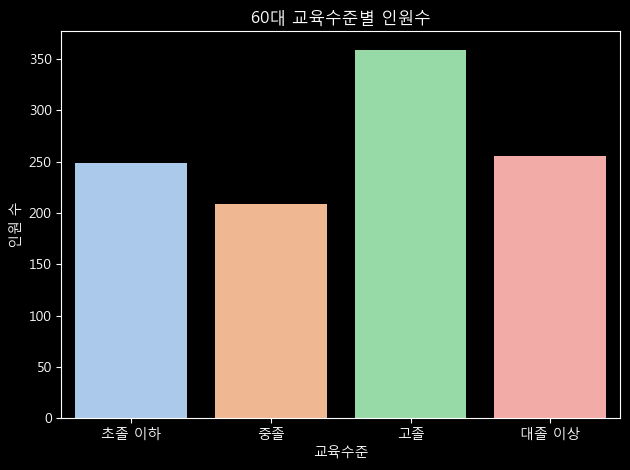

In [106]:
# 그래프 그리기
sns.countplot(data=data60, x='교육수준', palette='pastel')

# 숫자 → 한글 레이블 지정
plt.xticks(ticks=[0, 1, 2, 3], labels=['초졸 이하', '중졸', '고졸', '대졸 이상'])

plt.title("60대 교육수준별 인원수")
plt.xlabel("교육수준")
plt.ylabel("인원 수")
plt.tight_layout()
plt.show()

- 60대 인구에서 교육수준별 분포를 살펴본 결과, 고졸 비율이 가장 높고 초졸 이하 및 대졸 이상 비율도 고르게 분포되어 있다.
- 이는 60대 집단이 교육수준 간 비교 분석에 적합한 표본 분포를 갖추고 있음을 시사한다.

/var/folders/s0/flnd6hf15vs62n5vkdlhyg_m0000gn/T/ipykernel_60524/815404069.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data60, x='성별', palette='pastel')


<Axes: xlabel='성별', ylabel='count'>

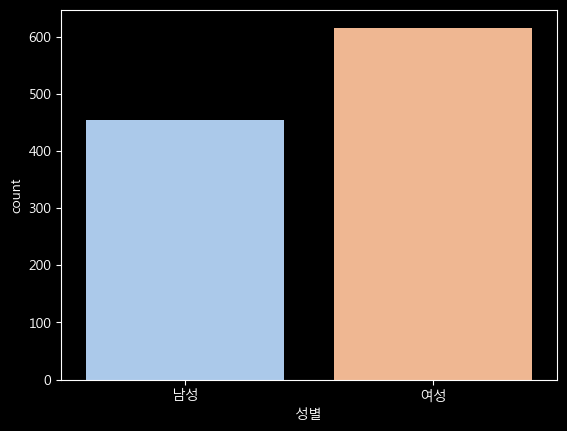

In [107]:
# 그래프 그리기
sns.countplot(data=data60, x='성별', palette='pastel')

- 60대 데이터에서 여성의 수가 남성보다 많으며, 전체적으로 여성 약 620명, 남성 약 460명 수준으로 확인된다.
- 성별 간 차이는 있으나 두 집단 모두 충분한 표본 수를 확보하고 있어 비교 분석에 무리가 없다.

## 탐구질문1. 교육수준에 따른 운동 실천율의 차이가 있는가?

### 데이터 분포도

In [139]:
data60_ex = data60[~data60['근력운동_1주'].isin([8, 9])] #8,9 제거
#data_exercise

data60_ex['운동일수'] = data60_ex['근력운동_1주'].map({
    1: '전혀 안 함',
    2: '1일',
    3: '2일',
    4: '3일',
    5: '4일',
    6: '5일 이상'
})

/var/folders/s0/flnd6hf15vs62n5vkdlhyg_m0000gn/T/ipykernel_60524/3964112636.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data60_ex['운동일수'] = data60_ex['근력운동_1주'].map({


In [ ]:
ex_cross = pd.crosstab(data60_ex['교육수준'], data60_ex['운동여부'], normalize='index')
ex_cross.index = ex_cross.index.map({1: '초졸 이하', 2: '중졸', 3: '고졸', 4: '대졸 이상'})

ex_cross

/var/folders/s0/flnd6hf15vs62n5vkdlhyg_m0000gn/T/ipykernel_60524/3357702790.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data60_ex['운동여부'] = data60_ex['운동일수'].apply(lambda x: 0 if x == '전혀 안 함' else 1)


운동여부,0,1
교육수준,,
초졸 이하,0.814346,0.185654
중졸,0.793814,0.206186
고졸,0.651026,0.348974
대졸 이상,0.574899,0.425101


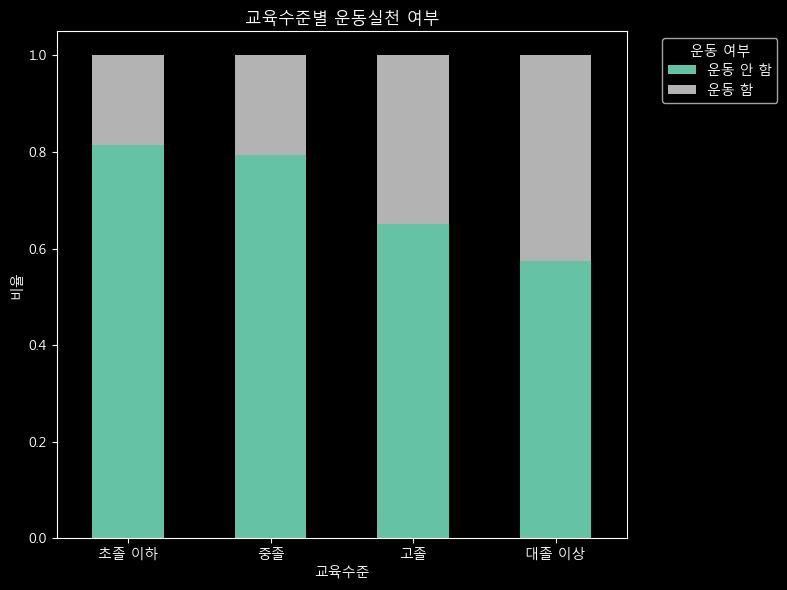

In [110]:
ex_cross.columns = ['운동 안 함', '운동 함']

ex_cross.plot(kind='bar', stacked=True, colormap='Set2', figsize=(8, 6))
plt.title("교육수준별 운동실천 여부")
plt.xlabel("교육수준")
plt.ylabel("비율")
plt.xticks(rotation = 0)
plt.legend(title="운동 여부", bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

- 60대 집단에서 교육수준이 높을수록 운동을 실천하는 비율이 증가하는 경향이 나타난다.
- 특히 초졸 이하 집단은 운동 실천률이 가장 낮고, 대졸 이상 집단에서 상대적으로 높은 운동 참여율을 보였다

### 카이제곱 검정

In [111]:
ex = pd.crosstab(data60_ex['교육수준'], data60_ex['운동여부'])
ex.index = ex.index.map({1: '초졸 이하', 2: '중졸', 3: '고졸', 4: '대졸 이상'})
ex

운동여부,0,1
교육수준,,
초졸 이하,193,44
중졸,154,40
고졸,222,119
대졸 이상,142,105


In [112]:
chi2, p, dof, expected = sp.stats.chi2_contingency(ex)
print(f"Chi2 통계량: {chi2:.3f}")
print(f"p-value: {p}")
print(f"자유도: {dof}")

Chi2 통계량: 44.972
p-value: 9.380336148061347e-10
자유도: 3


- 가설 설정  
  - 귀무가설(H₀): 교육수준과 운동 실천 여부는 서로 독립적이다.  
  - 대립가설(H₁): 교육수준과 운동 실천 여부는 독립적이지 않다 (즉, 관련이 있다).

- 검정 결과  
  - Chi² 통계량: 44.972  
  - 자유도(df): 3  
  - p-value: 9.38e-10

- 해석  
  p-value = 9.38e-10 < 0.05 이므로 귀무가설은 기각된다.  
  따라서, 교육수준과 운동 실천 여부 사이에는 통계적으로 유의한 관계가 있다.  
  특히 60대 집단에서 교육수준이 높을수록 운동을 실천하는 비율이 증가하는 경향이 나타난다.  
  이 관계는 단순한 표본 수 차이에 의한 것이 아니라 행동 양식의 차이를 반영한 결과로 해석된다.

### 로지스틱 회귀분석

In [113]:
ex60_model = data60[data60['근력운동_1주'].isin([1, 2, 3, 4, 5, 6])].copy()
ex60_model['운동여부'] = ex60_model['근력운동_1주'].apply(lambda x: 0 if x == 1 else 1)
ex60_model['교육수준'] = ex60_model['교육수준'].map({
    1: '초졸 이하', 2: '중졸', 3: '고졸', 4: '대졸 이상'})
ex60_model['sex'] = ex60_model['sex'].map({1: 'M', 2: 'F'})

ex60_model = ex60_model[['운동여부', '교육수준']].dropna()

In [114]:
model = smf.glm(
    formula = "운동여부 ~ 교육수준", 
    data = ex60_model, 
    family = sm.families.Binomial()).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                   운동여부   No. Observations:                 1019
Model:                            GLM   Df Residuals:                     1015
Model Family:                Binomial   Df Model:                            3
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -601.43
Date:                Sun, 08 Jun 2025   Deviance:                       1202.9
Time:                        23:23:33   Pearson chi2:                 1.02e+03
No. Iterations:                     4   Pseudo R-squ. (CS):            0.04409
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -0.6236      0.114     -5.488      0.000      -0.846      -0.401
교육수준[T.대졸 이상]     0.3217      0.172      1.874      0.061      -0.015       0.658
교육수준[T.중졸]       -0.7245      0.211     -3.438      0.001      -1.138      -0.312
교육수준[T.초졸 이하]    -0.8549      0.202     -4.232      0.000      -1.251      -0.459
=================================================================================
"""

- 60대 대상 로지스틱 회귀분석 결과, 교육수준이 낮을수록 운동 실천 확률이 유의미하게 낮았다.
- 특히 중졸과 초졸 이하 그룹은 고졸에 비해 운동 여부에 부정적인 영향을 미쳤으며, 이는 통계적으로 유의했다.
- 대졸 이상 그룹은 고졸보다 실천 확률이 다소 높았으나, 유의수준 0.05에서는 통계적으로 유의하지 않았다(p=0.061).
- 전체적으로 교육수준이 높을수록 운동 실천 가능성이 증가하는 경향을 보였다.

## 탐구질문2. 교육수준에 따른 흡연 및 음주에 대한 경험 차이가 있는가?

In [115]:
# 기존 분석에서 성별이 중요한 영향을 미친 변수였으므로, 성별을 '남성'으로 고정하여 편향 최소화
data60_smoke = data60[data60['흡연여부'].isin([1, 2, 3])] 
data60_smoke = data60[data60['성별'] == '남성']
data60_smoke

,sex,age,교육수준,근력운동_1주,흡연여부,음주빈도_1년,BMI,수축기혈압,이완기혈압,당화혈색소,연령대,성별
16,1,68,4.0,5.0,8.0,1.0,23.4,137.0,85.0,5.3,60대,남성
50,1,65,2.0,1.0,3.0,2.0,25.2,124.0,85.0,6.6,60대,남성
94,1,65,2.0,1.0,8.0,1.0,19.0,96.0,63.0,5.1,60대,남성
111,1,64,4.0,1.0,3.0,5.0,22.6,134.0,87.0,5.6,60대,남성
130,1,60,4.0,1.0,3.0,3.0,22.6,114.0,77.0,5.8,60대,남성
...,...,...,...,...,...,...,...,...,...,...,...,...
6830,1,62,3.0,6.0,3.0,5.0,21.9,117.0,78.0,5.9,60대,남성
6832,1,68,2.0,9.0,3.0,6.0,27.5,149.0,78.0,5.9,60대,남성
6838,1,67,3.0,1.0,1.0,6.0,20.1,124.0,80.0,5.1,60대,남성
6889,1,61,4.0,1.0,3.0,4.0,19.9,117.0,81.0,5.7,60대,남성


/var/folders/s0/flnd6hf15vs62n5vkdlhyg_m0000gn/T/ipykernel_60524/1000683323.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data60_smoke['흡연상태'] = data60_smoke['흡연여부'].map({1:'매일', 2:'가끔', 3:'끊음'})


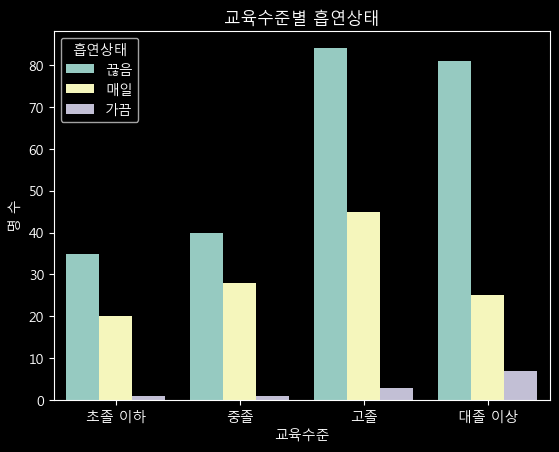

In [116]:
data60_smoke['흡연상태'] = data60_smoke['흡연여부'].map({1:'매일', 2:'가끔', 3:'끊음'})

sns.countplot(x='교육수준', hue='흡연상태', data=data60_smoke)
plt.xticks(ticks=[0, 1, 2, 3], labels=['초졸 이하', '중졸', '고졸', '대졸 이상'])
plt.title('교육수준별 흡연상태')
plt.xlabel('교육수준')
plt.ylabel('명 수')
plt.legend(title='흡연상태')
plt.show()

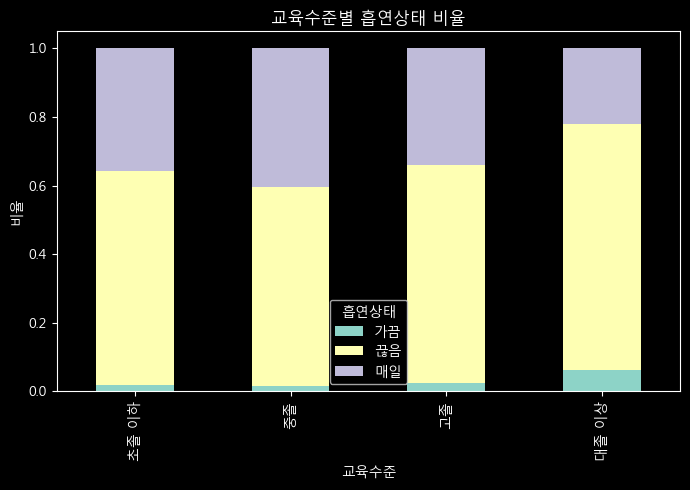

In [117]:
smoke_cross = pd.crosstab(data60_smoke['교육수준'], data60_smoke['흡연상태'], normalize='index')

smoke_cross.plot(kind='bar', stacked=True, figsize=(7,5))
plt.xticks(ticks=[0, 1, 2, 3], labels=['초졸 이하', '중졸', '고졸', '대졸 이상'])
plt.title('교육수준별 흡연상태 비율')
plt.xlabel('교육수준')
plt.ylabel('비율')
plt.legend(title='흡연상태')
plt.tight_layout()
plt.show()

- 60대 남성의 교육수준별 흡연 상태를 비교한 결과, 전반적으로 ’과거 흡연’과 ‘현재 흡연’ 비율에 큰 차이는 없었다.
- 다만, 초졸 이하에서는 ‘매일 흡연’ 비율이 다소 높게 나타났고, 중졸 이상에서는 ‘끊음’ 비중이 상대적으로 높았다.
- 전체적으로 교육수준에 따른 흡연 행동의 경향은 뚜렷하지 않지만, 일부 수준에서 흡연 형태 차이가 관찰된다.

In [118]:
smoke60 = pd.crosstab(data60_smoke['교육수준'], data60_smoke['흡연상태'])
smoke60.index = smoke60.index.map({1: '초졸 이하', 2: '중졸', 3: '고졸', 4: '대졸 이상'})
smoke60

흡연상태,가끔,끊음,매일
교육수준,,,
초졸 이하,1,35,20
중졸,1,40,28
고졸,3,84,45
대졸 이상,7,81,25


In [135]:
print(data60_smoke['흡연상태'].unique())
print(data60_smoke['교육수준'].unique())

[nan '끊음' '매일' '가끔']
[4. 2. 3. 1.]


In [134]:
df = data60_smoke[['교육수준', '흡연상태']].dropna()
corr, p = spearmanr(data60_smoke['교육수준'], data60_smoke['흡연상태'])
print(f"스피어만 상관계수: {corr:.3f}, p-value: {p:.3f}")

스피어만 상관계수: nan, p-value: nan


In [120]:
data60_smoke['흡연상태'].value_counts()

흡연상태
끊음    240
매일    118
가끔     12
Name: count, dtype: int64

In [121]:
data60_smoke['흡연상태'].value_counts()
data60_smoke['흡연이진'] = data60_smoke['흡연상태'].map({
    '끊음': 0,
    '가끔': 1,
    '매일': 1
})

smoke60_data = data60_smoke[['흡연이진', '교육수준', 'age', 'sex']].dropna()

smoke_model = smf.glm(
    formula="흡연이진 ~ 교육수준", 
    data=smoke60_data, 
    family=sm.families.Binomial()).fit()

smoke_model.summary()


/var/folders/s0/flnd6hf15vs62n5vkdlhyg_m0000gn/T/ipykernel_60524/2664239748.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data60_smoke['흡연이진'] = data60_smoke['흡연상태'].map({


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                   흡연이진   No. Observations:                  370
Model:                            GLM   Df Residuals:                      368
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -238.60
Date:                Sun, 08 Jun 2025   Deviance:                       477.19
Time:                        23:23:36   Pearson chi2:                     370.
No. Iterations:                     4   Pseudo R-squ. (CS):           0.006820
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.1460      0.311     -0.470      0.638      -0.755       0.463
교육수준          -0.1674      0.105     -1.591      0.112      -0.374       0.039
==============================================================================
"""

- 60대 남성의 교육수준이 흡연 여부(이진 변수)에 미치는 영향을 분석한 결과, 교육수준의 회귀계수는 -0.1243으로 나타났으나 통계적으로 유의하지 않았다(p = 0.285).
- 이는 교육수준이 흡연 여부에 유의미한 영향을 미치지 않는다는 것을 의미한다.
- Pseudo R² 값도 0.0025로 매우 낮아 모형 설명력 또한 거의 없는 수준이다.
- 따라서 교육수준은 60대 남성의 흡연 여부를 예측하는 데 결정적인 변수가 아니라고 볼 수 있다.

In [122]:
data60_drink = data60[~data60['음주빈도_1년'].isin([8, 9])]
data60_drink

,sex,age,교육수준,근력운동_1주,흡연여부,음주빈도_1년,BMI,수축기혈압,이완기혈압,당화혈색소,연령대,성별
16,1,68,4.0,5.0,8.0,1.0,23.4,137.0,85.0,5.3,60대,남성
17,2,66,4.0,3.0,8.0,1.0,20.1,115.0,63.0,5.5,60대,여성
21,2,61,3.0,6.0,8.0,4.0,21.6,96.0,63.0,5.4,60대,여성
50,1,65,2.0,1.0,3.0,2.0,25.2,124.0,85.0,6.6,60대,남성
51,2,67,2.0,1.0,8.0,2.0,17.9,121.0,72.0,5.3,60대,여성
...,...,...,...,...,...,...,...,...,...,...,...,...
6850,2,64,3.0,1.0,8.0,3.0,27.8,132.0,74.0,5.7,60대,여성
6884,2,67,3.0,1.0,8.0,2.0,20.0,117.0,67.0,5.3,60대,여성
6889,1,61,4.0,1.0,3.0,4.0,19.9,117.0,81.0,5.7,60대,남성
6906,1,65,3.0,6.0,3.0,5.0,24.6,126.0,80.0,5.5,60대,남성


/var/folders/s0/flnd6hf15vs62n5vkdlhyg_m0000gn/T/ipykernel_60524/1584903281.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data60_drink['음주빈도'] = data60_drink['음주빈도_1년'].map({1:'하지않음', 2:'아주가끔', 3:'가끔',


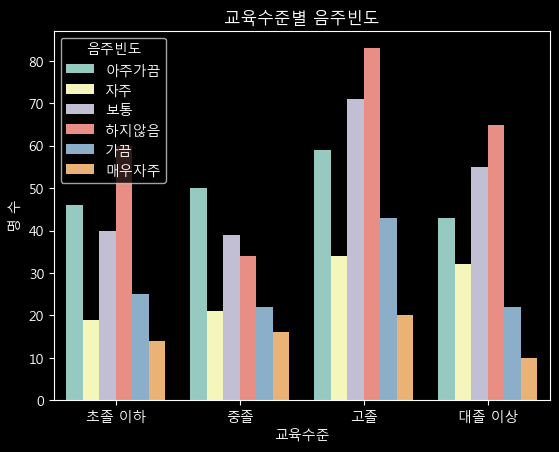

In [123]:
data60_drink['음주빈도'] = data60_drink['음주빈도_1년'].map({1:'하지않음', 2:'아주가끔', 3:'가끔',
                                               4:'보통', 5:'자주',6:'매우자주'})

sns.countplot(x='교육수준', hue='음주빈도', data=data60_drink)
plt.xticks(ticks=[0, 1, 2, 3], labels=['초졸 이하', '중졸', '고졸', '대졸 이상'])
plt.title('교육수준별 음주빈도')
plt.xlabel('교육수준')
plt.ylabel('명 수')
plt.legend(title='음주빈도')
plt.show()

In [124]:
corr, p = spearmanr(data60_drink['교육수준'], data60_drink['음주빈도'])
print(f"스피어만 상관계수: {corr:.3f}, p-value: {p:.3f}")

스피어만 상관계수: 0.031, p-value: 0.342


In [125]:
data60_drink['음주빈도_정수'] = data60_drink['음주빈도_1년']

/var/folders/s0/flnd6hf15vs62n5vkdlhyg_m0000gn/T/ipykernel_60524/921100910.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data60_drink['음주빈도_정수'] = data60_drink['음주빈도_1년']


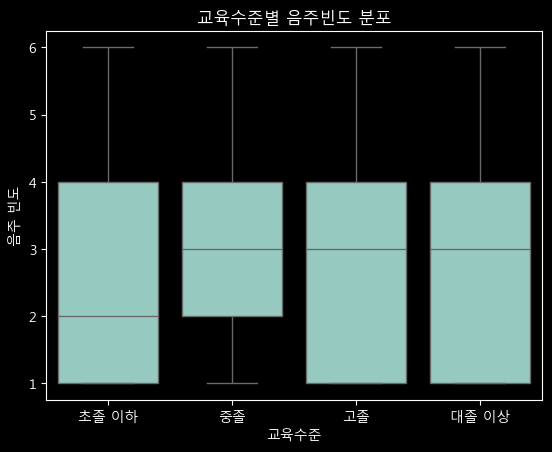

In [126]:
sns.boxplot(x='교육수준', y='음주빈도_정수', data=data60_drink)
plt.xticks(ticks=[0, 1, 2, 3], labels=['초졸 이하', '중졸', '고졸', '대졸 이상'])
plt.xlabel("교육수준")
plt.ylabel("음주 빈도")
plt.title("교육수준별 음주빈도 분포")
plt.show()


- 그래프에 따르면, 교육수준에 따른 음주 빈도 분포에는 뚜렷한 차이가 보이지 않는다.
- 모든 교육수준에서 음주 빈도의 중앙값은 유사하며, 전체 분포 범위(1~6단계)도 거의 동일하다.
- 따라서 60대 남성의 음주 빈도는 교육수준에 따라 특별히 높거나 낮아지는 경향은 관찰되지 않는다.

In [127]:
data60_drink = data60_drink.dropna(subset=['음주빈도', '교육수준'])
data60_drink['음주빈도'] = pd.Categorical(data60_drink['음주빈도'], ordered=True)
drink60_model = OrderedModel(
    data60_drink['음주빈도'], data60_drink[['교육수준']], distr='logit')

res = drink60_model.fit(method='bfgs')
res.summary()

Optimization terminated successfully.
         Current function value: 1.697189
         Iterations: 20
         Function evaluations: 22
         Gradient evaluations: 22


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:                   음주빈도   Log-Likelihood:                -1566.5
Model:                   OrderedModel   AIC:                             3145.
Method:            Maximum Likelihood   BIC:                             3174.
Date:                Sun, 08 Jun 2025                                         
Time:                        23:23:38                                         
No. Observations:                 923                                         
Df Residuals:                     917                                         
Df Model:                           1                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
교육수준           0.0433      0.054      0.802      0.422      -0.062       0.149
가끔/매우자주       -1.8678      0.172    -10.864      0.000      -2.205      -1.531
매우자주/보통       -0.6809      0.126     -5.397      0.000      -0.928      -0.434
보통/아주가끔        0.0988      0.065      1.525      0.127      -0.028       0.226
아주가끔/자주       -0.1359      0.065     -2.090      0.037      -0.263      -0.008
자주/하지않음       -0.6295      0.092     -6.807      0.000      -0.811      -0.448
==============================================================================
"""

- 60대를 대상으로 한 순서형 로지스틱 회귀분석 결과, 교육수준의 계수는 0.0433으로 나타났으며 p-value는 0.422로 통계적으로 유의하지 않았다.
- 이는 교육수준이 음주 빈도 수준에 유의한 영향을 미치지 않는다는 것을 의미한다.
- 따라서 교육 수준이 높다고 해서 음주 빈도가 증가하거나 감소하는 뚜렷한 경향은 보이지 않는다.

## 탐구질문3. 교육수준에 따른 건강지표 와의 유의미한 상관관계가 있는가?

In [128]:
data60_health = data60[['sex','age','교육수준', 'BMI', '수축기혈압', '이완기혈압', '당화혈색소']].dropna()  
data60_health

,sex,age,교육수준,BMI,수축기혈압,이완기혈압,당화혈색소
16,1,68,4.0,23.4,137.0,85.0,5.3
17,2,66,4.0,20.1,115.0,63.0,5.5
21,2,61,3.0,21.6,96.0,63.0,5.4
50,1,65,2.0,25.2,124.0,85.0,6.6
51,2,67,2.0,17.9,121.0,72.0,5.3
...,...,...,...,...,...,...,...
6889,1,61,4.0,19.9,117.0,81.0,5.7
6906,1,65,3.0,24.6,126.0,80.0,5.5
6907,2,63,3.0,22.0,139.0,87.0,5.7
6922,2,62,1.0,23.7,119.0,63.0,6.1


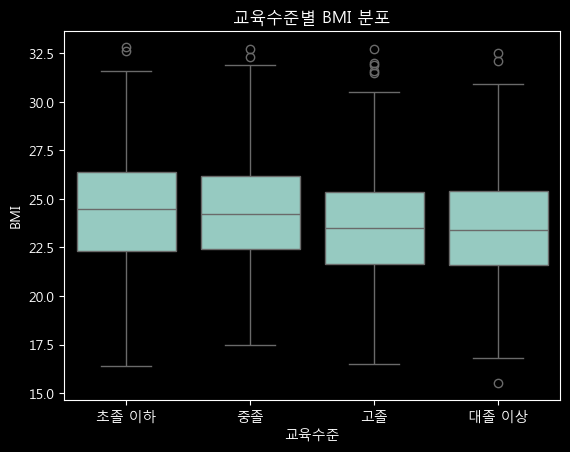

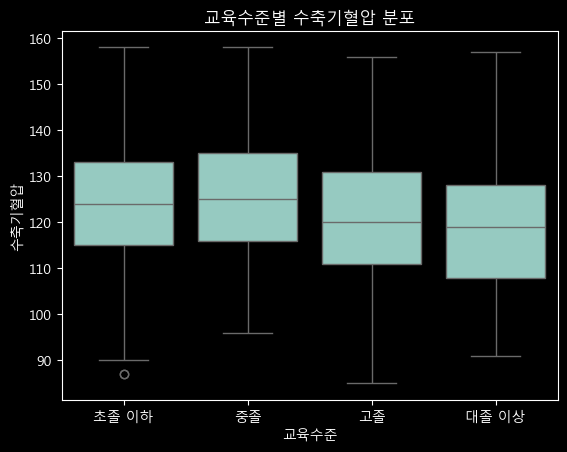

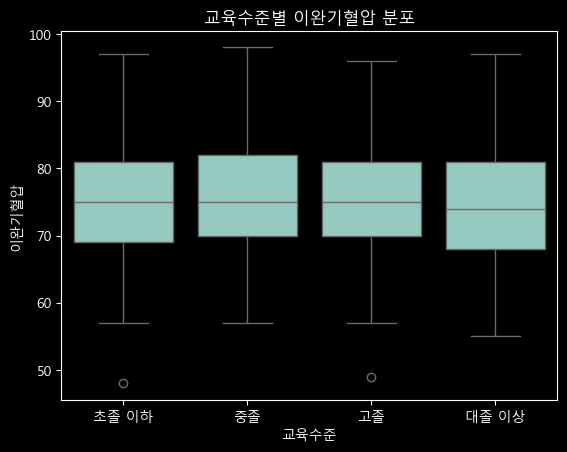

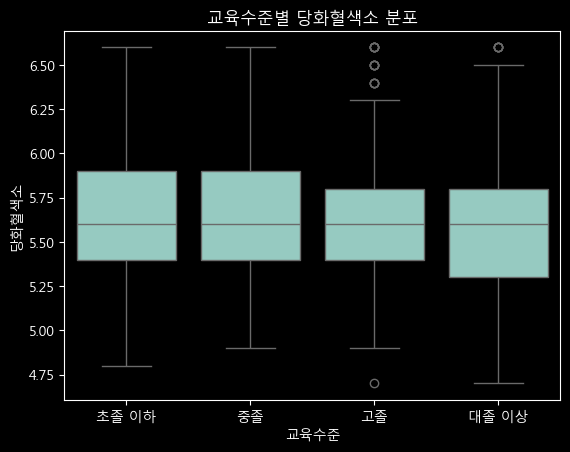

In [129]:
cols = ['BMI', '수축기혈압', '이완기혈압', '당화혈색소']
for col in cols:
    sns.boxplot(x='교육수준', y=col, data=data60_health)
    plt.xticks(ticks=[0, 1, 2, 3], labels=['초졸 이하', '중졸', '고졸', '대졸 이상'])
    plt.title(f'교육수준별 {col} 분포')
    plt.show()

- 60대의 교육수준별 건강지표 분포를 살펴본 결과, 전반적으로 교육수준이 높을수록 BMI, 수축기혈압, 이완기혈압, 당화혈색소 값이 살짝 낮아지는 경향을 보였다.
- 특히 고졸 이상 집단에서 건강지표의 중앙값이 상대적으로 낮고, 이상치(outlier)도 적은 편이었다.
- 초졸 이하나 중졸 집단은 분산이 크고 일부 지표에서는 극단값도 관찰되었다.
- 이는 교육수준이 건강관리나 생활습관과 관련이 있을 수 있음을 시사한다.

In [130]:
cols = ['BMI', '수축기혈압', '이완기혈압', '당화혈색소']
for col in cols:
    corr, p = pearsonr(data60_health['교육수준'], data60_health[col])
    print(f"{col}: 상관계수={corr:.3f}, p-value={p:.3f}")

BMI: 상관계수=-0.129, p-value=0.000
수축기혈압: 상관계수=-0.169, p-value=0.000
이완기혈압: 상관계수=-0.030, p-value=0.320
당화혈색소: 상관계수=-0.085, p-value=0.005


- 교육수준과 건강지표 간의 피어슨 상관분석 결과, BMI(r = -0.129), 수축기혈압(r = -0.169), 당화혈색소(r = -0.085)는 모두 음의 상관관계를 보이며 통계적으로 유의하였다(p < 0.05).
- 즉, 교육수준이 높을수록 해당 지표들이 낮아지는 경향이 있다.
- 반면 이완기혈압은 상관계수가 -0.031로 매우 약하고, 유의확률도 0.310으로 통계적으로 유의하지 않았다.
- 따라서 전반적으로 교육수준이 높을수록 건강 상태가 더 양호한 경향을 보이지만, 이완기혈압과의 직접적인 관련성은 뚜렷하지 않다.

In [131]:
model1 = smf.ols('BMI ~ 교육수준 + age + sex', data=data60_health.dropna()).fit()
print(model1.summary())

model2 = smf.ols('수축기혈압 ~ 교육수준 + age + sex', data=data60_health.dropna()).fit()
print(model2.summary())

model3 = smf.ols('이완기혈압 ~ 교육수준 + age + sex', data=data60_health.dropna()).fit()
print(model3.summary())

model4 = smf.ols('당화혈색소 ~ 교육수준 + age + sex', data=data60_health.dropna()).fit()
print(model4.summary())

                            OLS Regression Results                            
Dep. Variable:                    BMI   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     6.702
Date:                Sun, 08 Jun 2025   Prob (F-statistic):           0.000176
Time:                        23:23:39   Log-Likelihood:                -2697.6
No. Observations:                1072   AIC:                             5403.
Df Residuals:                    1068   BIC:                             5423.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     23.2685      2.312     10.066      0.0

In [132]:
model1 = ols('BMI ~ 교육수준', data=data60_health).fit()
anova_table1 = sm.stats.anova_lm(model1, typ=2)
anova_table1

tukey1 = pairwise_tukeyhsd(endog=data60_health['BMI'],
                          groups=data60_health['교육수준'],
                          alpha=0.05)
print(tukey1)

model2 = ols('수축기혈압 ~ 교육수준', data=data60_health).fit()
anova_table2 = sm.stats.anova_lm(model2, typ=2)
anova_table2

tukey2 = pairwise_tukeyhsd(endog=data60_health['수축기혈압'],
                          groups=data60_health['교육수준'],
                          alpha=0.05)
print(tukey2)

model3 = ols('이완기혈압 ~ 교육수준', data=data60_health).fit()
anova_table3 = sm.stats.anova_lm(model3, typ=2)
anova_table3

tukey3 = pairwise_tukeyhsd(endog=data60_health['이완기혈압'],
                          groups=data60_health['교육수준'],
                          alpha=0.05)
print(tukey3)

model4 = ols('당화혈색소 ~ 교육수준', data=data60_health).fit()
anova_table4 = sm.stats.anova_lm(model4, typ=2)
anova_table4

tukey4 = pairwise_tukeyhsd(endog=data60_health['당화혈색소'],
                          groups=data60_health['교육수준'],
                          alpha=0.05)
print(tukey4)


Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   1.0    2.0  -0.1835 0.9151 -0.9084  0.5414  False
   1.0    3.0  -0.8271 0.0048 -1.4643 -0.1899   True
   1.0    4.0  -0.9739 0.0016 -1.6623 -0.2855   True
   2.0    3.0  -0.6436 0.0664 -1.3159  0.0287  False
   2.0    4.0  -0.7904 0.0251 -1.5114 -0.0694   True
   3.0    4.0  -0.1468  0.933 -0.7796   0.486  False
----------------------------------------------------
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   1.0    2.0   1.0107 0.8605 -2.2945   4.316  False
   1.0    3.0  -3.5673 0.0088  -6.473 -0.6616   True
   1.0    4.0  -5.7178    0.0 -8.8568 -2.5788   True
   2.0    3.0   -4.578 0.0007 -7.6435 -1.5125   True
   2.0    4.0  -6.7285    0.0 -10.016  -3.441   True
   3.0    4.0  -2.1505 0.2212 -5.0359   0.735 

1. BMI
>교육수준이 높을수록 BMI는 유의미하게 낮아지는 경향을 보였으며(β = -0.3525, p < 0.001), 회귀모형의 설명력은 낮았다(R² = 0.018).
>성별과 나이는 BMI에 유의한 영향을 미치지 않았다.

2. 수축기혈압
>교육수준은 수축기혈압에 유의미한 음의 영향을 주었으며(β = -2.1481, p < 0.001), 나이와 성별도 유의하게 작용했다.
>모형 설명력은 R² = 0.041로 낮지만, 통계적으로 의미 있는 결과이다.

3. 이완기혈압
>교육수준은 이완기혈압과도 유의한 음의 상관관계를 보였고(β = -0.7090, p = 0.004), 나이와 성별도 유의한 영향을 주었다.
>다만 R² = 0.037로 설명력은 낮은 편이다.

4. 당화혈색소
>교육수준은 당화혈색소에 약하게 음의 영향을 미쳤고 통계적으로 유의하였다(β = -0.0218, p = 0.049).
>전체 모형의 설명력은 R² = 0.011로 매우 낮아 제한적인 해석이 필요하다.

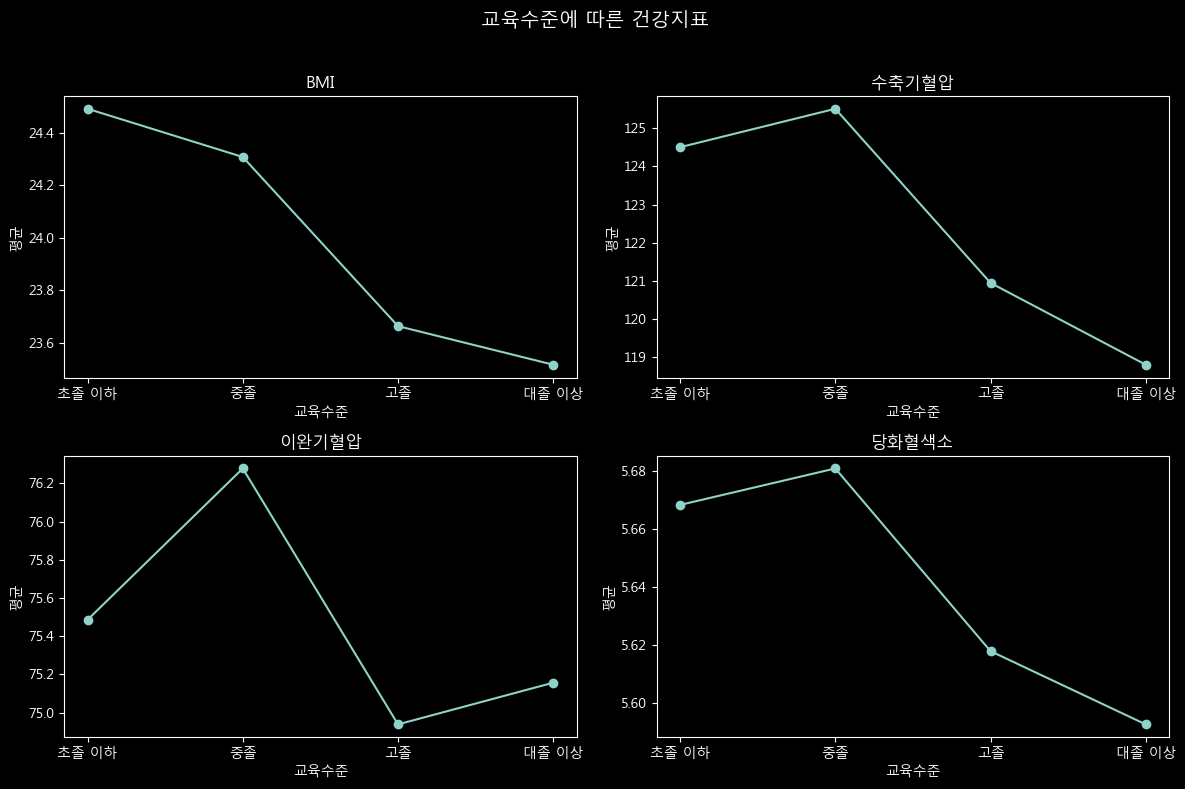

In [133]:
import matplotlib.pyplot as plt

# 교육수준별 건강지표 평균 
edu_mean = data60_health.groupby('교육수준')[['BMI', '수축기혈압', '이완기혈압', '당화혈색소']].mean()

# 시각화
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
labels = ['초졸 이하', '중졸', '고졸', '대졸 이상']

for ax, col in zip(axes.flat, ['BMI', '수축기혈압', '이완기혈압', '당화혈색소']):
    edu_mean[col].plot(marker='o', ax=ax)
    ax.set_title(col)
    ax.set_xticks([1, 2, 3, 4])
    ax.set_xticklabels(labels)
    ax.set_ylabel('평균')

fig.suptitle("교육수준에 따른 건강지표", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

- 그래프에 따르면 교육수준이 높을수록 BMI, 수축기혈압, 당화혈색소는 전반적으로 낮아지는 경향을 보였다.
- 이완기혈압은 뚜렷한 패턴은 없지만, 고졸 이상에서 비교적 낮은 수치를 나타낸다.
- 이는 교육수준이 일부 건강지표에 긍정적인 영향을 줄 수 있음을 시사한다.